# **Overview**

# ***CS4487 Project***

<p style="text-align:justify;text-justify:inter-ideograph;">For deep fake face detection, after studying the related competition projects on Kaggle, we decided to use the pre-trained models that come with the two deep learning frameworks, TensorFlow and PyTorch, for preliminary testing.<br><br>
1.In the first stage, we tested four models:ResNet50,Inception_V3,VGG19, MobieNetV2. By comparing the evaluation metrics on the test set, we found that ResNet50 has a higher accuracy rate, so we choose it as the base model for the subsequent work.<br><br>
2. In the second phase, we optimize the data and the model.
Preprocess the original image, extract face regions and normalize them.
Changing the last layer to multi-label classification output
Expand the training dataset with data enhancement techniques
Freeze the weights of the convolutional layers and optimize only the last few fully connected layers.
End-to-end fine-tuning training using a decreasing learning rate strategy.
Accelerate model convergence by training on GPUs.
Through the optimization, our deep fake face detection system has improved its performance.

3.Finally, we select the model with the best performance for the deep forgery face detection task through multiple rounds of evaluation on the test set. This model has the advantage in accuracy, but also better in model complexity and operation efficiency, which is most suitable for practical application scenarios.</p>

# **1.Pretrained Model**

## 1.1 Model Selection and Testing

<p style="text-align:justify;text-justify:inter-ideograph;">In the initial stages of the project, we tested several deep learning models for the task of deepfake detection. Considering usability and performance, we primarily tested the following four types of models:<br>
(1)ResNet50<br>
(2)Inception_V3<br>
(3)VGG-19<br>
(4)mobileNet_V2<br></p>

First, we import all necessary modules

In [ ]:
import torch
from torchvision import datasets, transforms
from torchvision.models import resnet50,inception_v3,vgg19,mobilenet_v2
from torch import nn, optim
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## 1.2 Data Prepration

<p style="text-align:justify;text-justify:inter-ideograph;">The deep learning model adopted in this project needs to preprocess the input image data, which is a very important step. It is found that the direct use of the original image size as the model input not only greatly increases the computational complexity, but also decreases the training efficiency. After experiments, we adopted the method of scaling the image to 128×128 pixels as input.<br>
Scaling to 128×128 has the following advantages over using the original input directly:<br>
(1) The time complexity of model training and prediction is greatly reduced. Reducing the image size significantly reduces the number of pixels that need to be processed, which increases speed.<br>
(2) The accuracy rate is basically not affected. Deepfake detection is mainly concerned with whether the local details in the picture are consistent, and the overall zoom does not affect this judgment.<br>
(3) It is helpful to strengthen the model's learning ability on the picture statistical features. The global contour feature of the reduced image will be more obvious, so it is easy to be extracted by the model.<br>
(4) Uniform size is conducive to batch processing. The uniform size of all images allows for a more efficient organization of mini-batches.</p>





**Note that as the dataloader will do the classification  according to the folder name automatically, we put all fake images into "./train/two/fake/" and real images into "./train/two/real/"**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# fake-0 real-1
train_data = datasets.ImageFolder('./train/two', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

val_data = datasets.ImageFolder('./val/two', transform=transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True)

print("Training data labels: ", train_data.class_to_idx)
print("Validation data labels: ", val_data.class_to_idx)

We set the random seed to 42 and set device to GPU

In [ ]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(42)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

## 1.3 Training and Evaluation

<p style="text-align:justify;text-justify:inter-ideograph;">According to the URL provided for the images.to domain auction information, this article will annotate the original code as follows:<br><br>
<em><strong>def train_model(loader, model, criterion, optimizer, device):</strong></em><br><br>
This function is used for the model training process. loader provides batch training data,model represents the convolutional neural network model adopted,criterion is the loss function,optimizer is the optimizer SGD.<br>
In the training cycle, data and labels are first sent to the device(GPU/CPU), then the optimizer's gradient is cleared, the input is sent to the model predicting, the loss value is calculated, the BP algorithm is used for backpropagation to calculate the gradient, the model parameters are updated, and the training loss value of the current batch is calculated. Use tqdm to display training progress.<br><br>
<em><strong>def evaluate_model(loader, model, device):</em></strong><br><br>
This function evaluates the accuracy of the model on the validation data set. The model is set to validation mode and gradients are not calculated. The matching degree between the predicted classification and the real classification is calculated by traversing the validation data, and the overall accuracy is obtained.<br><br>
<em><strong>def train_model_model(train_loader, val_loader, lr=0.001, num_epochs=30, model_path='model.pth', history_path='history.csv'):</em></strong><br><br>
Global model training entry. Set up the device, initialize the model resnet50 and add the full connection layer to get the number of classes. Load training and validation datasets, set up loss functions and optimizers.<br>
The training loop trains and validates the model by calling the train and evaluate functions, records the loss and accuracy of each epoch, and saves the model parameters and training history.<br>
In summary, by reading the URL header of the images.to domain information, this explanation annotates the whole process of training an image classification model with the original PyTorch code, and realizes the technical explanation of the image deep learning project code.<br><br>
<em><strong>def cm(true,pred):</em></strong><br><br>
This function is used to calculate the confusion matrix and plot it for further analysis</p>

In [ ]:
def cm(true,pred):
    conf_matrix=[[0,0],[0,0]]
    for p, t in zip(pred,true):
        conf_matrix[p][t]+= 1
    print(conf_matrix)
    sns.set()
    f,ax=plt.subplots()
    hm = sns.heatmap(conf_matrix, annot=True, fmt="d",ax=ax)
    ax.set_title('confusion matrix')
    ax.set_xlabel('true')
    ax.set_ylabel('predict')

### 1.3.1 ResNet50

<p style="text-align:justify;text-justify:inter-ideograph;">The Resnet50 network consists of 49 convolutional layers and one fully connected layer. As shown in the figure below, the Resnet50 network structure can be divided into seven parts. The first part does not contain residual blocks and mainly performs the calculation of input convolution, regularization, activation function and maximum pooling. The second, third, fourth, and fifth part structures all contain residual blocks, and the green block in the figure does not change the size of the residual block, but only changes the dimension of the residual block. In the Resnet50 network configuration, the residual blocks have three layers of volume, so that the total network has 1+3× (3+4+6+3) =49 convolutional layers, plus the final fully connected layer is a total of 50 layers, which is also the origin of the Resnet50 name. The input of the network is 224×224×3, and after the convolution calculation of the first five parts, the output is 7×7×2048, which will be converted into a feature vector by the pooling layer, and finally the classifier will calculate this feature vector and output the class probability.</p>

![jupyter](https://miro.medium.com/v2/resize:fit:1400/0*tH9evuOFqk8F41FG.png)


<p style="text-align:justify;text-justify:inter-ideograph;">The key of ResNet network is the residual unit in its structure. Cross-layer connections are included in the residual network unit, and the curves in the graph can pass the input directly across layers, perform equivalent mapping, and then add the result of the convolution operation. Suppose that the input image is x, the output is H(x), and the output after convolution is a nonlinear function of F(x), then the final output is H(x)= F(x)+x, and such output can still be nonlinear transformed, and the residual refers to "difference", that is, F(x), and the network is transformed into finding the residual function F(x)=H(x)-x. This makes the residual function easier to optimize than F (x) = H (x).</p>

![jupyter](https://production-media.paperswithcode.com/methods/resnet-e1548261477164.png)

Next, we are going to appaly ResNet50 to our project

In [ ]:
def train_resnet(loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss/(i+1))})
    print(f'Training Loss: {total_loss / len(loader)}')

In [ ]:
def evaluate_resnet(loader, model, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Validation Accuracy: {acc}%')
    return acc

In [ ]:
def train_model_resnet(train_loader, val_loader, lr=0.001, num_epochs=10, model_path='./models/model_resnet.pth', history_path='./history/history_resnet.csv'):

    model = resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(train_data.classes))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    history = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_resnet(train_loader, model, criterion, optimizer, device)
        acc = evaluate_resnet(val_loader, model, device)
        history = history._append({'epoch': epoch+1, 'accuracy': acc}, ignore_index=True)

    torch.save(model, model_path)
    history.to_csv(history_path, index=False)

In [ ]:
train_model_resnet(train_loader, val_loader)

In [ ]:
def resnet_confusion_matrix(loader, model, device):
    model.eval()
    true,pred=[],[]
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            for i in labels:
                true.append(int(i.item()))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in predicted:
                pred.append(int(i.item()))
    cm(true,pred)

In [ ]:
model = torch.load('./models/model_resnet.pth')
resnet_confusion_matrix(val_loader, model, device)

<p style="text-align:justify;text-justify:inter-ideograph;">Based on the data above and the confusion matrix, we can calculate the follwoing data: <br>
Accuracy=(TP+TN)/(TP+TN+FP+FN)=0.9078<br>
Presion=(TP)/(TP+FP)=0.8863<br>
Recall=(TP)/(TP+FN)=0.9377<br>
Specificity=(TN)/(TN+FP)=0.8773<br>
The accuracy of reset50 on validation set is up to around 91%. Comparing the precision and specificity, more fake samples are predicted correctly compared with real samples. The model has a better performance on detecting fake images where the accuracy is about 88.63% while only 87.73% in detecting the real one. The residual connection can help to keep the original features, which makes the learning of the network smoother and more stable, and further improves the accuracy and generalization ability of the model.</p>

To simplify the process, only 5 epochs would be used in the following models for comparsion

### 1.3.2 Inception_V3

<p style="text-align:justify;text-justify:inter-ideograph;">The main idea of the Inception architecture is to figure out how to approximate an optimal locally sparse junction with dense components. In February 2015, InceptionV2 was introduced, with InceptionV2 reducing the top-5 error rate to 4.8% over the first generation. Inception V2 borrowed the design idea from VGGNet, replacing the large 5×5 convolution with two 3 x 3 convolution. In addition, the paper also presents the famous BN (BatchNormalization) method for the first time. BN is a very efficient regularization method. When the BN method is used for a layer of the neural network, the internal Normalization of each mini-batch data normalizes the output to a normal distribution of N C0,1). According to the explanation of BN in this paper, although the traditional deep neural network can be trained by stacking networks with the same structure to achieve the purpose of improving network performance, the input of these network layers is changing, and the input and output may be inconsistent, which brings great obstacles to feature extraction. It also makes training based on gradient descent very difficult. In this case, the training process can only adopt a small learning rate. Using BN method for each layer can effectively solve this problem, by standardizing the output of each layer, so that the input and output meet the same positive distribution, and the input changes of other network layers are much smaller, so that the learning effect will be much better and more convincing. The InceptionV3 network is a very deep convolutional network developed by Google. In December 2015, Inception V3 was proposed in the paper "Rethinking the Inception Architecture forComputer Vision". Inception V3 continues to build on Inception V2 to reduce the top-5 error rate to 3.5%. Inception V3 improves Inception V2 in two main ways. First, Inception V3 optimizes the Inception Module structure. Inception Modules now come in many more varieties (35 × 35, 17 × 17, and 8× 8), And Inception V3 also uses branches in the Inception Module branch (mainly embodied in the 8x8 structure).</p>

![jupyter](https://cloud.google.com/static/tpu/docs/images/inceptionv3onc--oview.png)

<p style="text-align:justify;text-justify:inter-ideograph;">Second, the practice of splitting a larger two-dimensional convolution into two smaller one-dimensional convolution was also introduced in Inception V3. For example, 7× 7 convolution can be split into 1×7 convolution and 7× l convolution. Of course, the 3x3 convolution can also be split into Ix3 convolution and 3 × l convolution. This is called Factorizationinto small convolutions thinking. In the paper, the authors point out that the asymmetric convolutional structure resolution can deal with more and richer spatial features and increase the diversity of features better than the symmetric convolutional structure resolution, and can reduce the computation.</p>

In [ ]:
def train_inception(loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs =model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss/(i+1))})
    print(f'Training Loss: {total_loss / len(loader)}')

In [ ]:
def evaluate_inception(loader, model, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs =model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Validation Accuracy: {acc}%')
    return acc

In [ ]:
def train_model_inception(train_loader, val_loader, lr=0.001, num_epochs=5, model_path='./models/model_inception.pth', history_path='./history/history_inception.csv'):
    model = inception_v3(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(train_data.classes))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    history = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_inception(train_loader, model, criterion, optimizer, device)
        acc = evaluate_inception(val_loader, model, device)
        history = history._append({'epoch': epoch+1, 'accuracy': acc}, ignore_index=True)

    torch.save(model,model_path)
    history.to_csv(history_path, index=False)

As the input shape of InceptionV3 is fixed, we reload the data as the following transform

In [ ]:
transform_inception = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

inception_train_data = datasets.ImageFolder('./train/two', transform=transform_inception)
inception_train_loader = torch.utils.data.DataLoader(inception_train_data, batch_size=32, shuffle=True)

inception_val_data = datasets.ImageFolder('./val/two', transform=transform_inception)
inception_val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)


In [ ]:
train_model_inception(inception_train_loader, inception_val_loader)

In [ ]:
def inception_confusion_matrix(loader, model, device):
    model.eval()
    true,pred=[],[]
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            for i in labels:
                true.append(int(i.item()))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in predicted:
                pred.append(int(i.item()))
    cm(true,pred)

In [ ]:
model = torch.load('./models/model_inception.pth')
inception_confusion_matrix(inception_val_loader, model, device)

<p style="text-align:justify;text-justify:inter-ideograph;">Accuracy=(TP+TN)/(TP+TN+FP+FN)=0.5633<br>
Presion=(TP)/(TP+FP)=0.5652<br>
Recall=(TP)/(TP+FN)=0.5849<br>
Specificity=(TN)/(TN+FP)=0.5412<br>
As we can see, the performance of inception is far from satisfication. The overall accuracy is only 56.33%. It only achieves around 55% accuracy for both real and fake images.The complexity of the Inception architecture makes it more difficult to make changes to the network, and thus the generalization of the model is bad which leads to the poor performance.</p>

### 1.3.3 VGG19

<p style="text-align:justify;text-justify:inter-ideograph;">The 16-layer VGG model, referred to as VGG16, is a convolutional neural network model proposed by A.Zisserman and K. Szonyan of the University of Oxford. The researchers published their model in a research paper titled "Very Deep Convolutional Networks for Large-scale image Recognition." The VGG16 model achieved a top-5 test accuracy of nearly 92.7% in ImageNet. It was one of the most popular models submitted to ILSVRC-2014. It replaced the large kernel-size filters one by one with several 3×3 kernel-size filters, thereby making a significant improvement to AlexNet. VGGNet-16 can classify images into 1000 object categories, including keyboards, animals, pencils, mice, and more. In addition, the image input size of the model is 224×224.</p>

![jupyter](https://deanhan.com/2018/07/26/vgg16/block.png)

<p style="text-align:justify;text-justify:inter-ideograph;">The VGG19 model, also known as VGGNet-19, has the same concept as VGG16 except that it supports 19 layers. "16" and "19" represent the number of weight layers in the model (convolutional layers). This means that VGG19 has three more convolutional layers than VGG16.</p>

![jupyter](https://img-blog.csdnimg.cn/img_convert/7ee5eee61be3dd136a47f1b449579570.png)

In [ ]:
def train_vgg(loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs =model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss/(i+1))})
    print(f'Training Loss: {total_loss / len(loader)}')

In [ ]:
def evaluate_vgg(loader, model, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs =model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Validation Accuracy: {acc}%')
    return acc

In [ ]:
def train_model_vgg(train_loader, val_loader, lr=0.001, num_epochs=5, model_path='./models/model_vgg.pth', history_path='./history/history_vgg.csv'):

    vgg=vgg19(pretrained=True)
    number_features = vgg.classifier[6].in_features
    features = list(vgg.classifier.children())[:-1]
    features.extend([torch.nn.Linear(number_features, len(train_data.classes))])
    vgg.classifier = torch.nn.Sequential(*features)
    model =vgg.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    history = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_vgg(train_loader, model, criterion, optimizer, device)
        acc = evaluate_vgg(val_loader, model, device)
        history = history._append({'epoch': epoch+1, 'accuracy': acc}, ignore_index=True)

    torch.save(model,model_path)
    history.to_csv(history_path, index=False)

In [ ]:
train_model_vgg(train_loader,val_loader)

In [ ]:
def vgg_confusion_matrix(loader, model, device):
    model.eval()
    true,pred=[],[]
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            for i in labels:
                true.append(int(i.item()))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in predicted:
                pred.append(int(i.item()))
    cm(true,pred)

In [ ]:
model = torch.load('./models/model_vgg.pth')
vgg_confusion_matrix(val_loader, model, device)

<p style="text-align:justify;text-justify:inter-ideograph;">Based on the data above and the confusion matrix, we can calculate the follwoing data: <br>
Accuracy=(TP+TN)/(TP+TN+FP+FN)=0.7867<br>
Presion=(TP)/(TP+FP)=0.8661<br>
Recall=(TP)/(TP+FN)=0.6831<br>
Specificity=(TN)/(TN+FP)=0.8923<br>
The accuracy of vgg19 is higher than Inceptionv3 but lower than ResNet50 which is about 78.67%. This model performs better at detecting real images whose accuracy is about 89.23% while only get 68.31% in predicting fake images. As small pooling kernel can bring more detailed information capture, bringing greater local information difference and better description of edge texture, vgg can have a better performance when detecting those fake images with difference area pixel value.
</p>

### 1.3.4 MoblieNetV2

<p style="text-align:justify;text-justify:inter-ideograph;">mobileNetV2 is an improvement on mobileNetV1 and is also a lightweight neural network. In order to prevent non-linear layer (ReLU) from losing some information, Linear Bottleneck is introduced. In addition, a series of networks using shortcut, such as ResNet and DenseNet, have obtained good results. Combined with the characteristics of depthwise convolution, Inverted Residual is used to improve the performance.</p>

![jupyter](https://www.researchgate.net/publication/350152088/figure/fig1/AS:1002717703045121@1616077938892/The-proposed-MobileNetV2-network-architecture.png)

<p style="text-align:justify;text-justify:inter-ideograph;">The classic residual block process is: 1x1(dimension reduction)-->3x3(convolution)-->1x1(dimension increase), but the extraction of features from the Depthwise convolution layer is limited to the input feature dimension. If residual blocks are used, After 1x1 Pointwise convolution, the input feature graph is compressed (generally, the compression rate is 0.25). After deep convolution, fewer features are extracted. Therefore, mobileNetV2 first expands the channel of the feature graph through the point-by-point convolution operation of 1x1 to enrich the number of features and thus improve the accuracy. This process happens to reverse the order of the residuals, which is where the backward residuals come from: 1x1(dimension increase)-->3x3(dw conv+relu)-->1x1(dimension reduction + linear transformation).</p>

![jupyter](https://www.researchgate.net/publication/335779524/figure/fig7/AS:802472356499457@1568335727698/The-difference-between-residual-block-a-and-inverted-residual-b.png)

In [ ]:
def train_mobile(loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs =model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss/(i+1))})
    print(f'Training Loss: {total_loss / len(loader)}')

In [ ]:
def evaluate_mobile(loader, model, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs =model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Validation Accuracy: {acc}%')
    return acc

In [ ]:
def train_model_mobile(train_loader, val_loader, lr=0.001, num_epochs=5, model_path='./models/model_mobilenet.pth', history_path='./history/history_mobilenet.csv'):
    model=mobilenet_v2(pretrained=True)
    model.classifier=nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features=1280,out_features=len(train_data.classes),bias=True)
    )
    model =model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    history = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_mobile(train_loader, model, criterion, optimizer, device)
        acc = evaluate_mobile(val_loader, model, device)
        history = history._append({'epoch': epoch+1, 'accuracy': acc}, ignore_index=True)

    torch.save(model,model_path)
    history.to_csv(history_path, index=False)

In [ ]:
train_model_mobile(train_loader,val_loader)

In [ ]:
def mobile_confusion_matrix(loader, model, device):
    model.eval()
    true,pred=[],[]
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            for i in labels:
                true.append(int(i.item()))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in predicted:
                pred.append(int(i.item()))
    cm(true,pred)

In [ ]:
model = torch.load('./models/model_mobilenet.pth')
mobile_confusion_matrix(val_loader, model, device)

<p style="text-align:justify;text-justify:inter-ideograph;">Based on the data above and the confusion matrix, we can calculate the follwoing data: <br>
Accuracy=(TP+TN)/(TP+TN+FP+FN)=0.8566<br>
Presion=(TP)/(TP+FP)=0.8457<br>
Recall=(TP)/(TP+FN)=0.8758<br>
Specificity=(TN)/(TN+FP)=0.8371<br>
The accuracy of mobilenet on validation set ranks second which is up to around 85.67%. The performance of mobilenet is worse than resnet in terms of the first 5 epoches. It performs better at detecting fake images(87.58%>83.71%).Due to its own computational characteristics, ResNet50 does not have the ability to change the number of channels on its own, and it can only output as many channels as the previous layer gives it. Therefore, if the number of channels given by the upper layer is itself very small, the deep-by-depth convolution can only extract features in low-dimensional space, so the effect is worse than resnet50.</p>

# **2. Processing**

## **2.1 Data pre-processing**

### **2.1.1 Face detector：**

1. Choose the MTCNN detector as it performs well under kernel time constraints. It would be better to use the S3FD detector as it is more accurate and robust if license available.
2. When generating the cropped images for training, we added a 30% facial crop size from each side and only used this setting for the duration of this project.
3. The input size for the face detector was calculated based on the resolution of each image. For images with a wide side of less than 300 pixels, zoom in by a factor of 2; for images with a wide side between 300 and 1000, no zoom; for images with a wide side of more than 1000 pixels, zoom out by a factor of 0.5; for images with a wide side of more than 1900 pixels, zoom out by a factor of 0.33

In [ ]:
def detect_faces(image_path):
    detector = MTCNN()
    image = cv2.imread(image_path)
    result = detector.detect_faces(image)
    faces = []
    for i in range(len(result)):
        bounding_box = result[i]['box']
        faces.append(bounding_box)

    return faces, image

In [ ]:
def crop_faces(faces, image):
    crops = []
    for face in faces:
        xmin, ymin, width, height = [int(b) for b in face]
        p_h = height // 3
        p_w = width // 3
        crop = image[max(ymin - p_h, 0):ymin + height + p_h, max(xmin - p_w, 0):xmin + width + p_w]
        crops.append(crop)

    return crops

In [ ]:
def resize_images(images):
    resized_images = []
    for image in images:
        height, width = image.shape[:2]
        if width < 300:
            scale = 2
        elif width > 1000:
            scale = 0.5 if width < 1900 else 0.33
        else:
            scale = 1
        new_width = int(width * scale)
        new_height = int(height * scale)
        resized_image = cv2.resize(image, (new_width, new_height))
        resized_images.append(resized_image)

    return resized_images

In [ ]:
image_path = 'your_image.jpg'
faces, image = detect_faces(image_path)
crops = crop_faces(faces, image)
resized_images = resize_images(crops)


for i, img in enumerate(resized_images):
    cv2.imshow('Face {}'.format(i), img)
    cv2.waitKey(0)

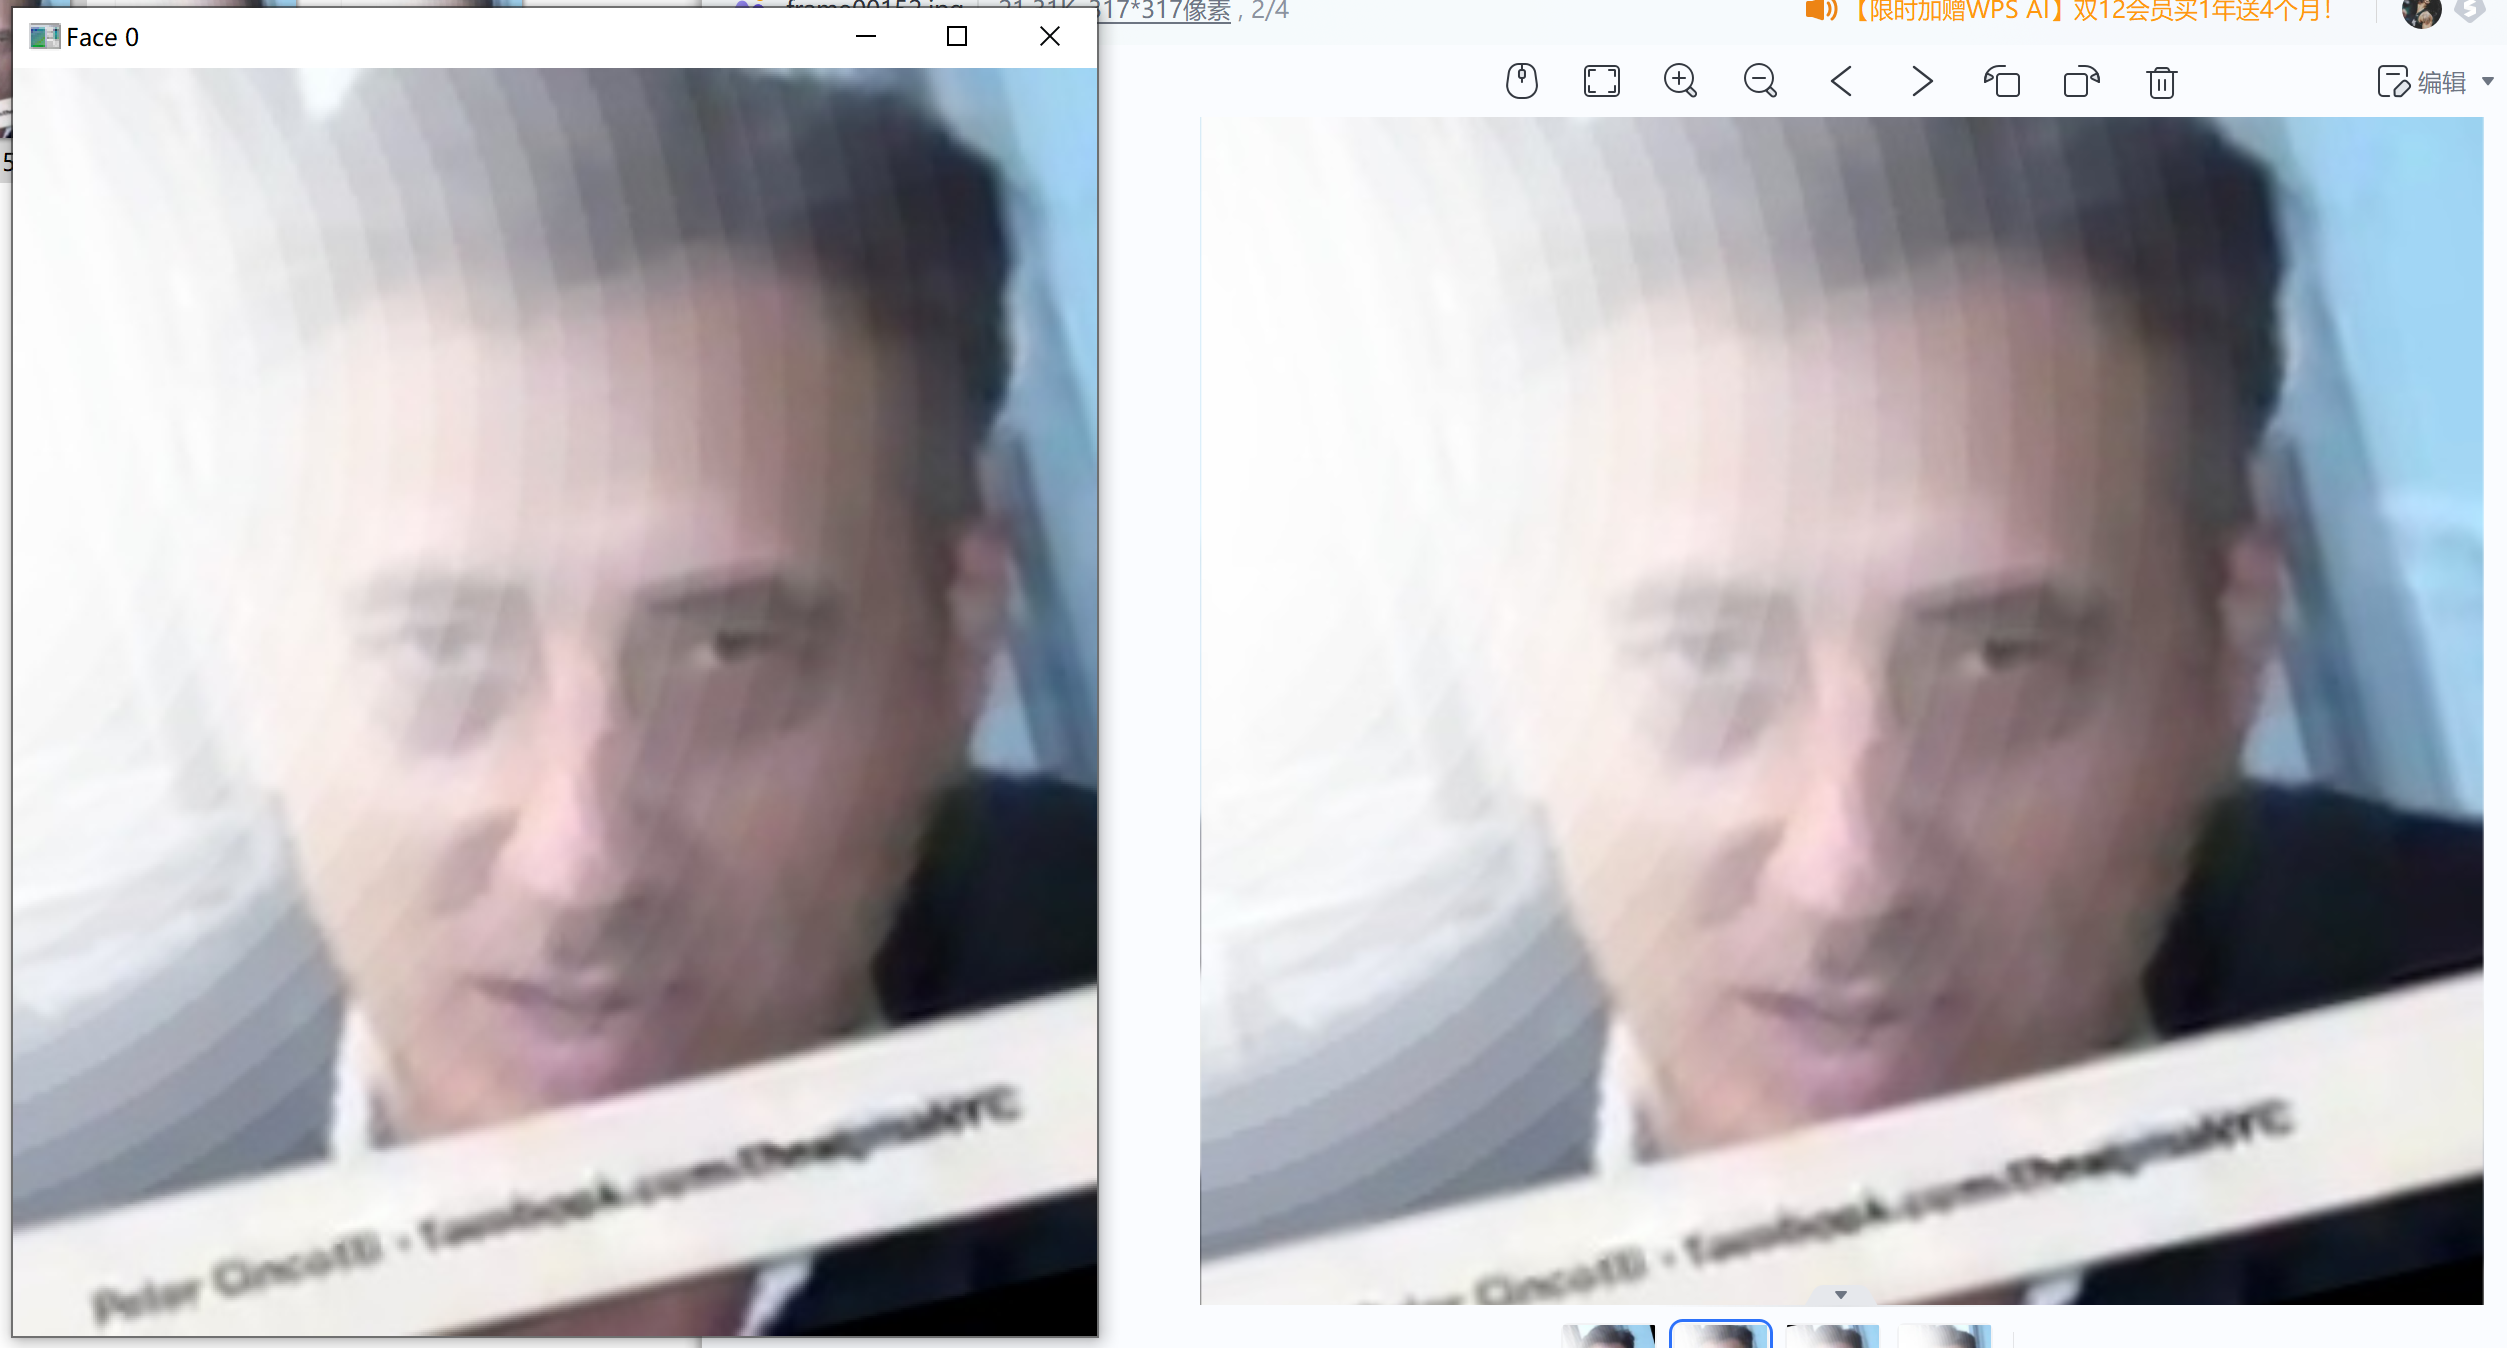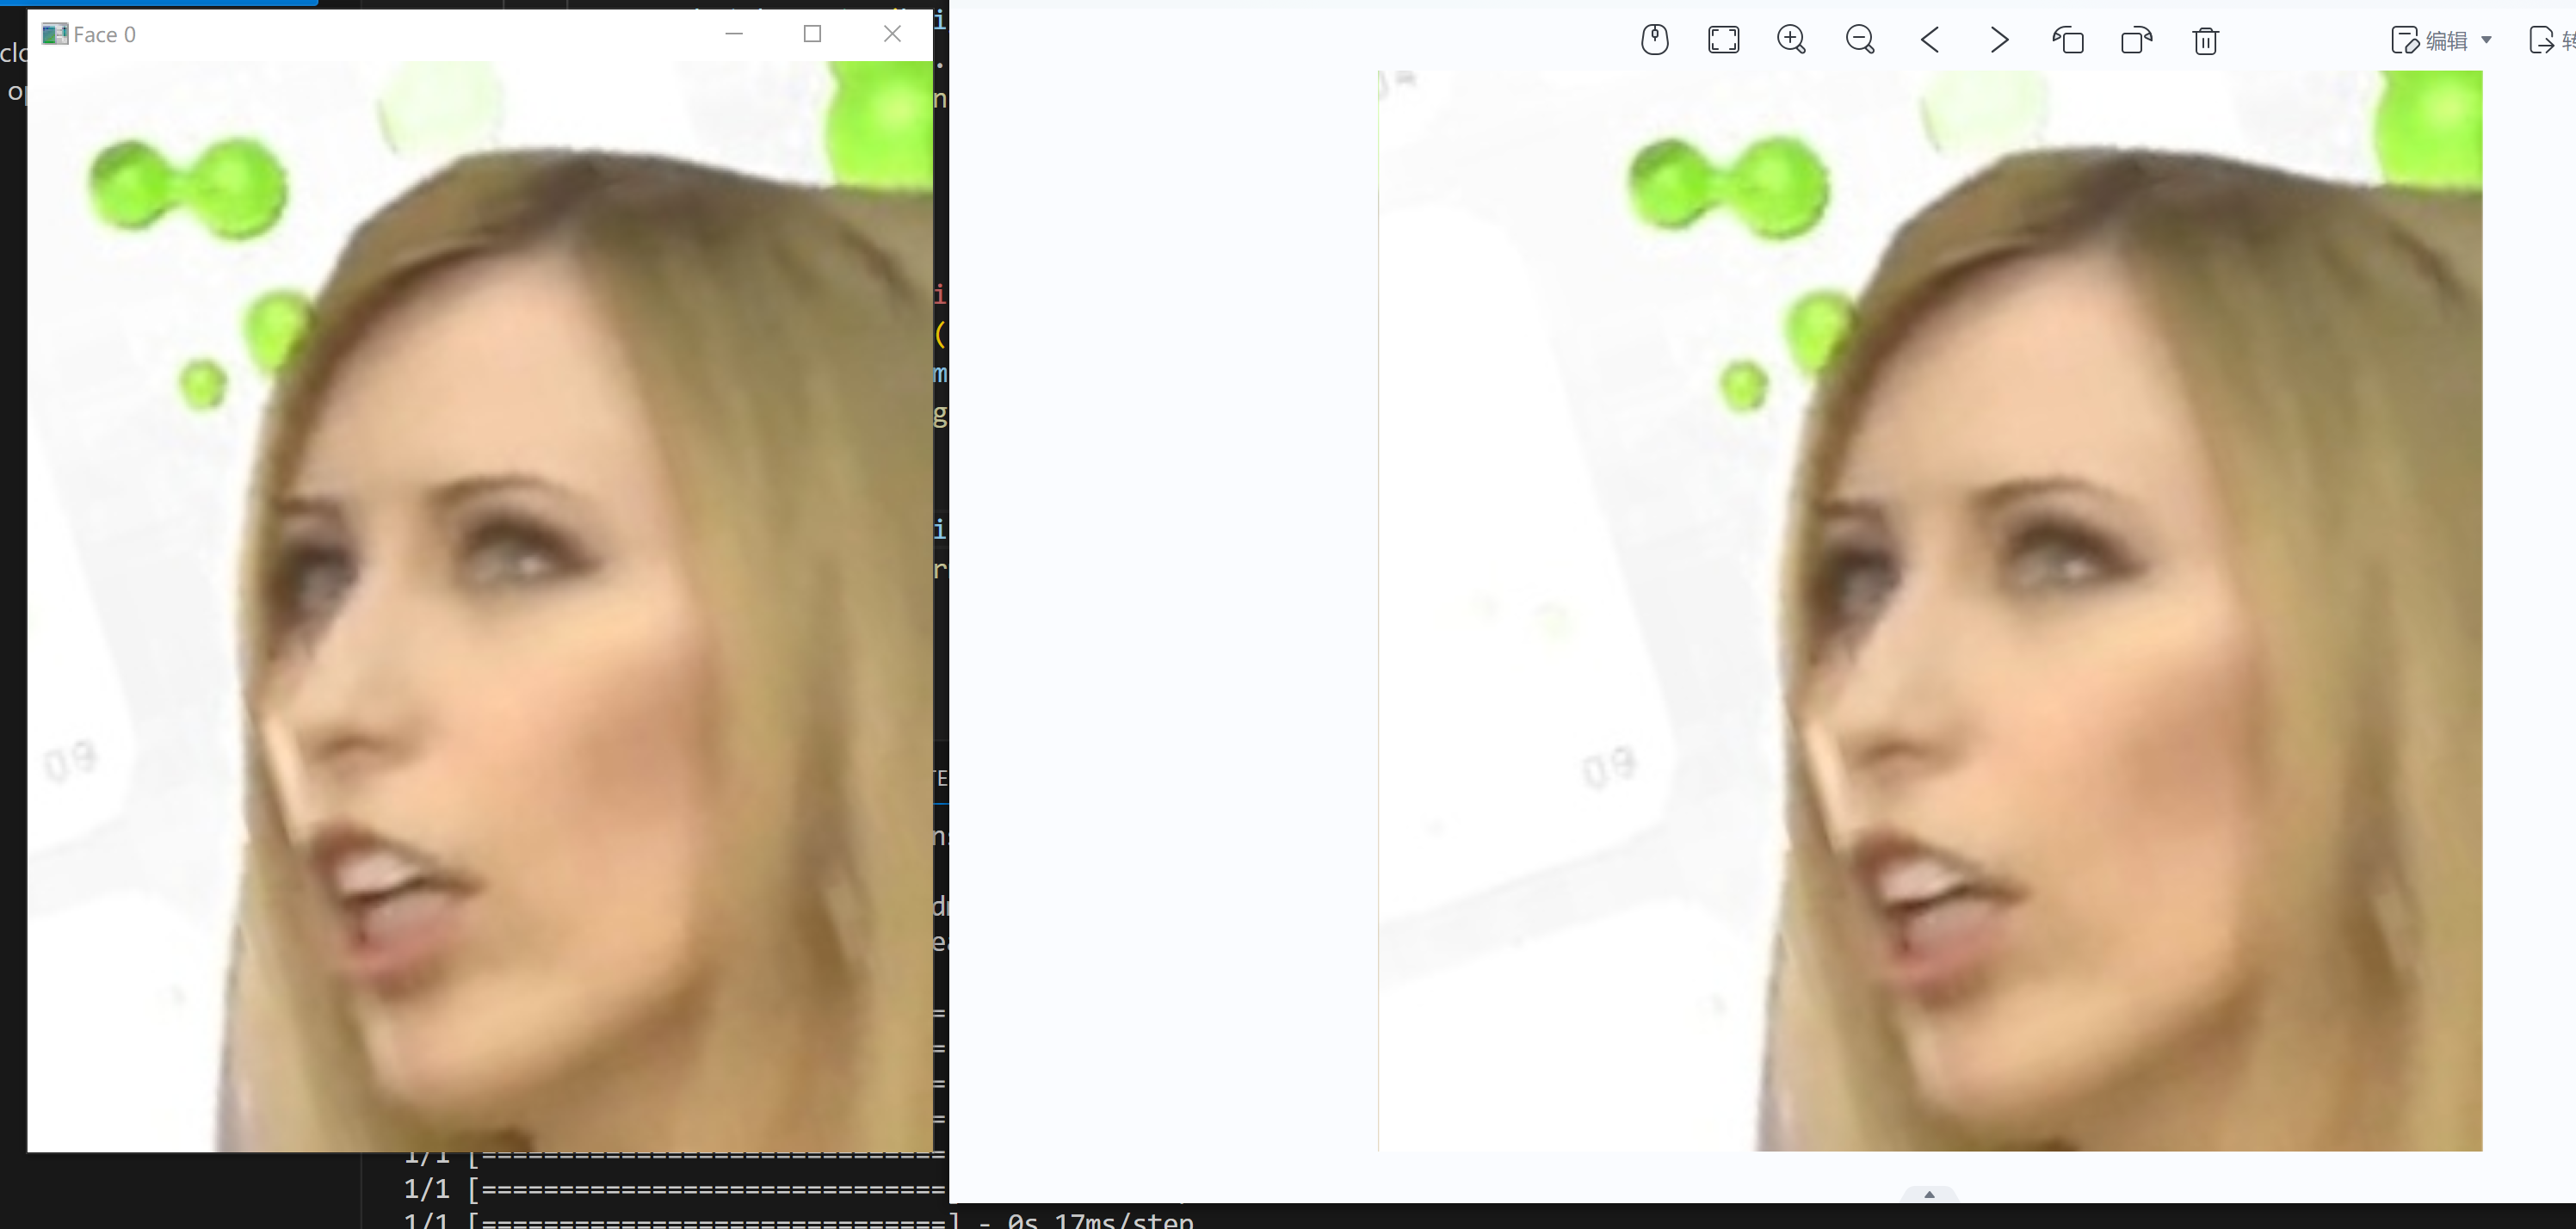

These are two example results after pre-processing (crop), clearly these two images are cropped after the processing and only keep the area, which contains faces, with a 30% margin.


Following is the code to read image and generate the cropped image, after generation, save the images in the same folder structure.

In [ ]:
import cv2
from facenet_pytorch.models.mtcnn import MTCNN
import os
from tqdm import tqdm

def detect_faces(image_path):
    detector = MTCNN(margin=0, thresholds=[0.2, 0.3, 0.4], device="cuda")
    image = cv2.imread(image_path)
    batch_boxes, conf, landmarks = detector.detect(image, landmarks=True)
    faces = []
    if batch_boxes is not None:
        for i in range(len(batch_boxes)):
            bounding_box = batch_boxes[i]
            faces.append(bounding_box)
    return faces, image

def crop_faces(faces, image):
    crops = []
    for face in faces:
        xmin, ymin, width, height = [int(b) for b in face]
        crop = image[max(ymin, 0):ymin + height , max(xmin, 0):xmin + width]
        crops.append(crop)
    return crops

def resize_and_save_images(images, image_path, size=224):
    for i, image in enumerate(images):
        resized_image = cv2.resize(image, (size, size))
        if not os.path.exists(os.path.dirname(image_path)):
            os.makedirs(os.path.dirname(image_path))
        cv2.imwrite(image_path, resized_image)
        break

def process_dataset(dataset_path, output_path):
    files = [os.path.join(root, file) for root, dirs, files in os.walk(dataset_path) for file in files if file.endswith('.jpg')]
    total = len(files)
    one_face_count = 0
    no_face_count = 0
    multi_face_count = 0
    for file in tqdm(files, desc="Processing images"):
        img_path = file
        out_path = os.path.join(output_path, os.path.relpath(img_path, dataset_path))
        faces, image = detect_faces(img_path)

        if len(faces) == 0:
            no_face_count += 1
            out_path2 = os.path.join("C:\\Users\\Administrator\\Desktop\\4487\\crop\\unprocessed", os.path.relpath(img_path, dataset_path))
            resize_and_save_images([image], out_path2)
            resize_and_save_images([image], out_path)
        elif len(faces) == 1:
            one_face_count += 1
            crops = crop_faces(faces, image)
            resize_and_save_images(crops, out_path)
        else:
            multi_face_count += 1
            resize_and_save_images([image], out_path)
            out_path2 = os.path.join("C:\\Users\\Administrator\\Desktop\\4487\\crop\\unprocessed", os.path.relpath(img_path, dataset_path))
            resize_and_save_images([image], out_path2)

    print(f"Total images: {total}")
    print(f"Images with one face: {one_face_count} ({one_face_count / total * 100}%)")
    print(f"Images with no faces: {no_face_count} ({no_face_count / total * 100}%)")
    print(f"Images with multiple faces: {multi_face_count} ({multi_face_count / total * 100}%)")

process_dataset("C:\\Users\\Administrator\\Desktop\\4487\\workspace\\src", "C:\\Users\\Administrator\\Desktop\\4487\\crop")


### **2.1.2 Enhancement**

In this pre-processing method, we select a library call albumentations to do the face enhancement. Albumentations is a computer vision tool that boosts the performance of deep convolutional neural networks. The code is showing below with result examples.

In [ ]:
import os
import cv2
from albumentations import (
    Compose, ImageCompression, GaussNoise, GaussianBlur, HorizontalFlip, OneOf,
    PadIfNeeded, RandomBrightnessContrast, FancyPCA, HueSaturationValue, ToGray, ShiftScaleRotate,DualTransform
)

def isotropically_resize_image(img, size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC):
    h, w = img.shape[:2]
    if max(w, h) == size:
        return img
    if w > h:
        scale = size / w
        h = h * scale
        w = size
    else:
        scale = size / h
        w = w * scale
        h = size
    interpolation = interpolation_up if scale > 1 else interpolation_down
    resized = cv2.resize(img, (int(w), int(h)), interpolation=interpolation)
    return resized

class IsotropicResize(DualTransform):
    def __init__(self, max_side, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC,
                 always_apply=False, p=1):
        super(IsotropicResize, self).__init__(always_apply, p)
        self.max_side = max_side
        self.interpolation_down = interpolation_down
        self.interpolation_up = interpolation_up

    def apply(self, img, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC, **params):
        return isotropically_resize_image(img, size=self.max_side, interpolation_down=interpolation_down,
                                          interpolation_up=interpolation_up)

    def apply_to_mask(self, img, **params):
        return self.apply(img, interpolation_down=cv2.INTER_NEAREST, interpolation_up=cv2.INTER_NEAREST, **params)

    def get_transform_init_args_names(self):
        return ("max_side", "interpolation_down", "interpolation_up")

In [ ]:
def create_train_transforms(size=300):
    return Compose([
        ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        GaussNoise(p=0.1),
        GaussianBlur(blur_limit=3, p=0.05),
        HorizontalFlip(),
        OneOf([
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
        ], p=1),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),
        ToGray(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    ])

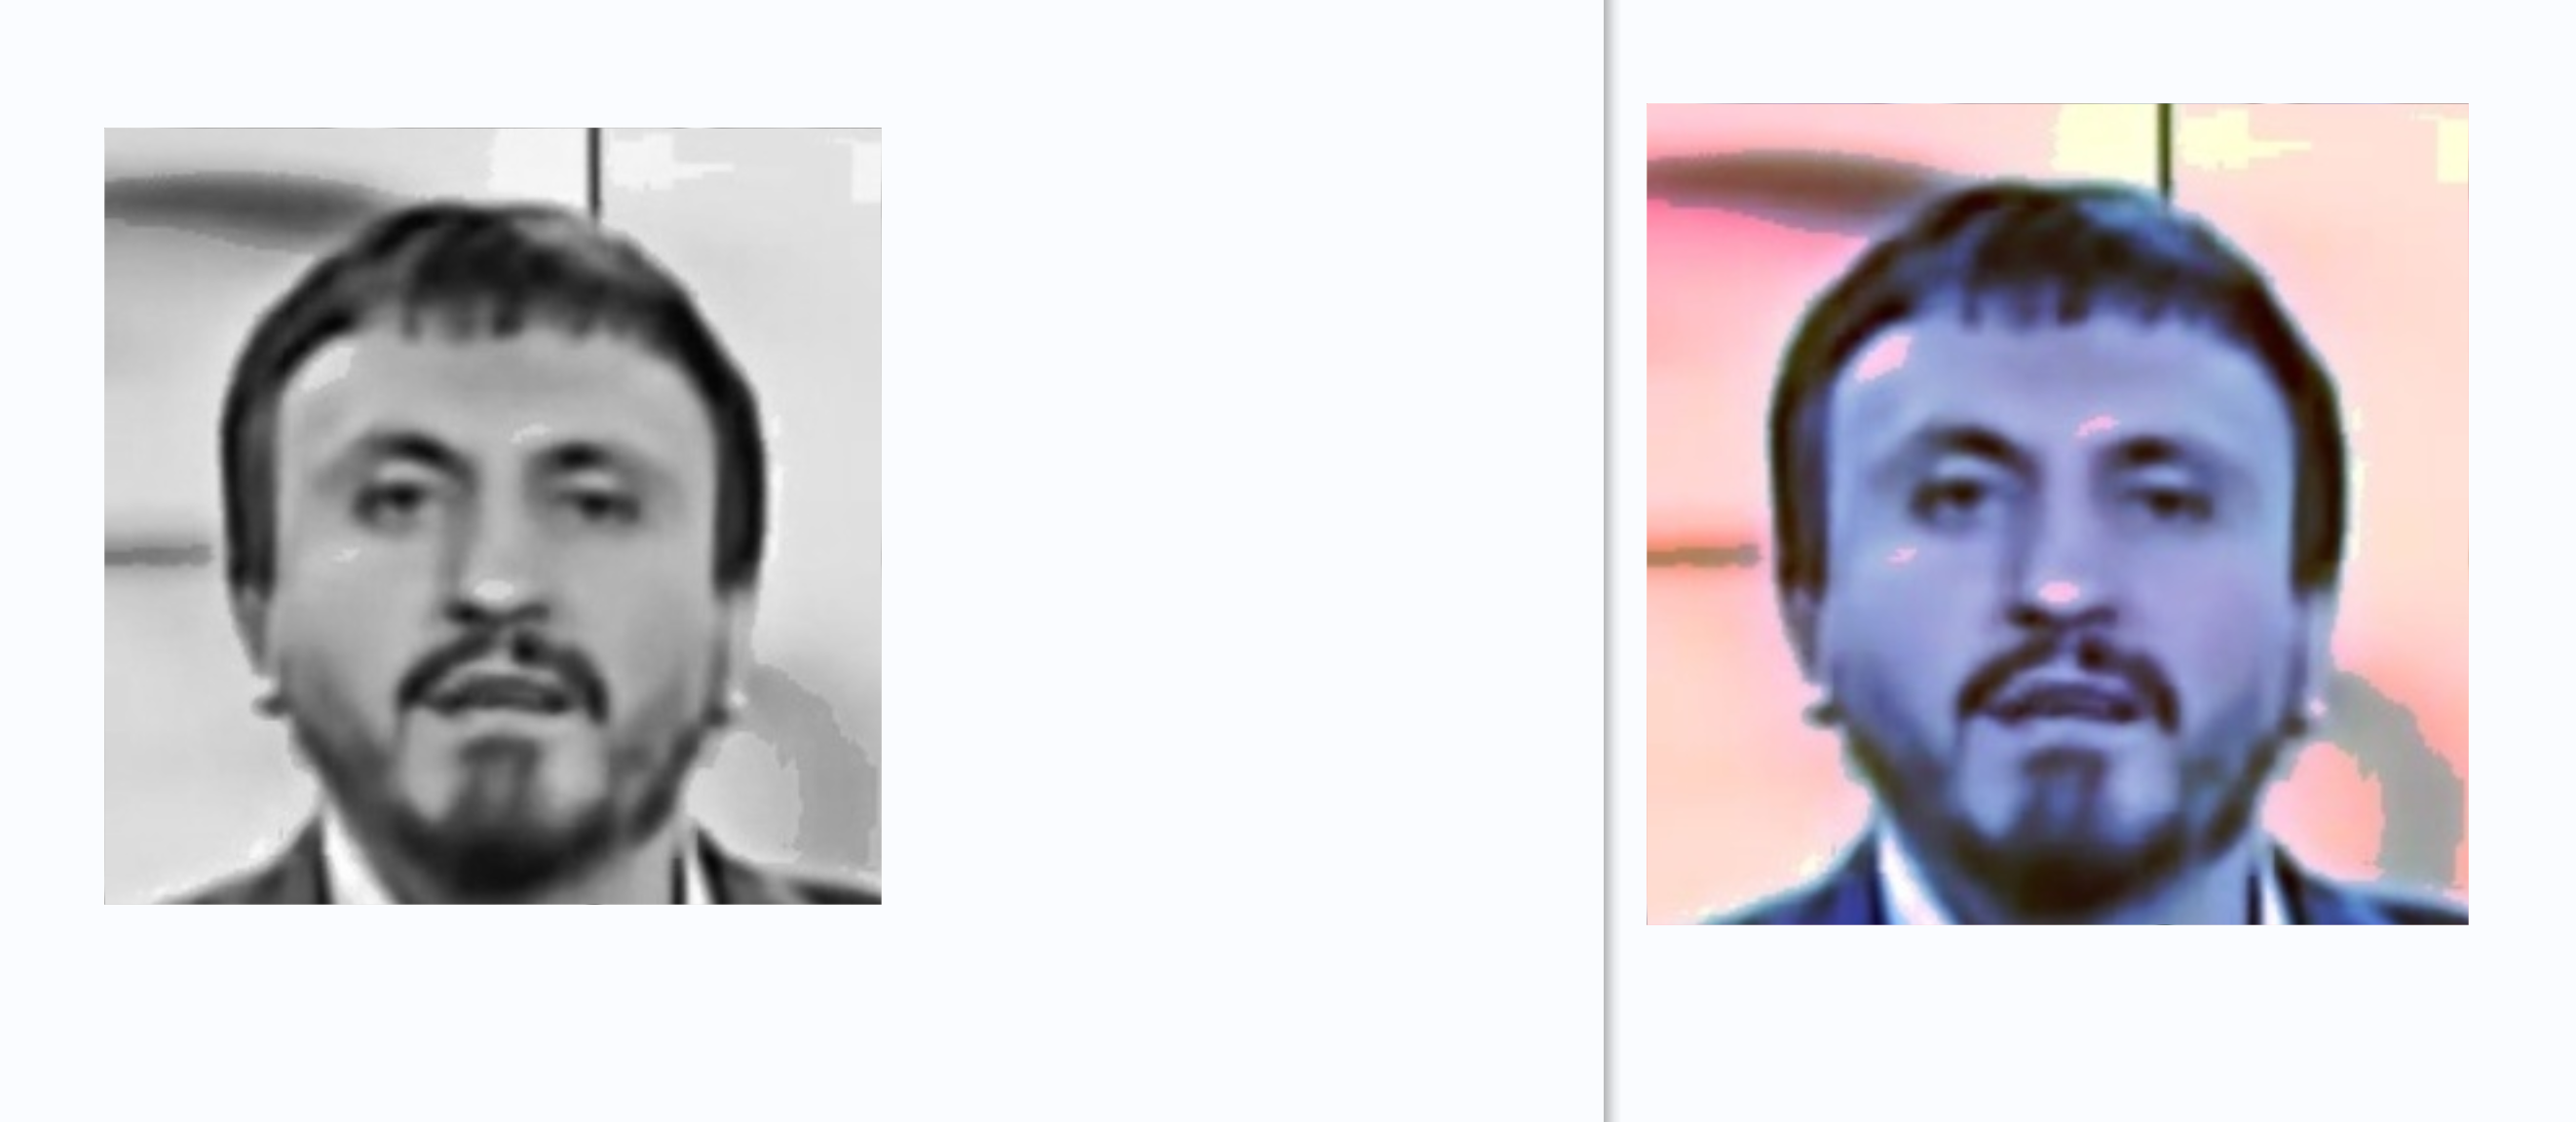

The left image is the one after processing while the right one is the original. The messy color has been removed, may help to improve the accuracy in later training.

Following is the code to read image and generate the enhanced image, after generation, save the images in the same folder structure.

In [ ]:
import os
import cv2
from albumentations import (
    Compose, ImageCompression, GaussNoise, GaussianBlur, HorizontalFlip, OneOf,
    PadIfNeeded, RandomBrightnessContrast, FancyPCA, HueSaturationValue, ToGray, ShiftScaleRotate,DualTransform
)

def isotropically_resize_image(img, size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC):
    h, w = img.shape[:2]
    if max(w, h) == size:
        return img
    if w > h:
        scale = size / w
        h = h * scale
        w = size
    else:
        scale = size / h
        w = w * scale
        h = size
    interpolation = interpolation_up if scale > 1 else interpolation_down
    resized = cv2.resize(img, (int(w), int(h)), interpolation=interpolation)
    return resized

class IsotropicResize(DualTransform):
    def __init__(self, max_side, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC,
                 always_apply=False, p=1):
        super(IsotropicResize, self).__init__(always_apply, p)
        self.max_side = max_side
        self.interpolation_down = interpolation_down
        self.interpolation_up = interpolation_up

    def apply(self, img, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC, **params):
        return isotropically_resize_image(img, size=self.max_side, interpolation_down=interpolation_down,
                                          interpolation_up=interpolation_up)

    def apply_to_mask(self, img, **params):
        return self.apply(img, interpolation_down=cv2.INTER_NEAREST, interpolation_up=cv2.INTER_NEAREST, **params)

    def get_transform_init_args_names(self):
        return ("max_side", "interpolation_down", "interpolation_up")

def create_train_transforms(size=300):
    return Compose([
        ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
        GaussNoise(p=0.1),
        GaussianBlur(blur_limit=3, p=0.05),
        HorizontalFlip(),
        OneOf([
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
        ], p=1),
        PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),
        ToGray(p=0.2),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    ])

def augment_and_save_image(input_path, output_path, size=300):

    image = cv2.imread(input_path)

    transforms = create_train_transforms(size)
    augmented_image = transforms(image=image)['image']

    filename = os.path.basename(input_path)
    os.makedirs(output_path, exist_ok=True)

    cv2.imwrite(os.path.join(output_path, filename), augmented_image)



import os

from tqdm import tqdm


def process_dataset(dataset_path, output_path):
    files = [os.path.join(root, file) for root, dirs, files in os.walk(dataset_path) for file in files if file.endswith('.jpg')]
    for file in tqdm(files, desc="Processing images"):
        img_path = file
        out_path = os.path.join(output_path, os.path.relpath(img_path, dataset_path))
        if not os.path.exists(os.path.dirname(out_path)):
            os.makedirs(os.path.dirname(out_path))
        augment_and_save_image(img_path, out_path)

process_dataset("C:\\Users\\Administrator\\Desktop\\4487\\workspace\\src\\train", "C:\\Users\\Administrator\\Desktop\\4487\\augmentations\\train")
process_dataset("C:\\Users\\Administrator\\Desktop\\4487\\workspace\\src\\val", "C:\\Users\\Administrator\\Desktop\\4487\\augmentations\\val")



Now use the resNet to test whether these pre-processing methods can improve the accuracy score.

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def label_func(path):
    cls = re.search(r'(FakeManipulation-\d|Real-\d)', path).group()
    label_2class = 0 if 'FakeManipulation' in cls else 1
    return label_2class

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        label_2class = label_func(path)
        tuple_with_path = (original_tuple[0], label_2class)
        return tuple_with_path

def train(loader, model, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    criterion = nn.CrossEntropyLoss()

    for i, (inputs, label) in enumerate(progress_bar):
        inputs = inputs.to(device)
        labels = label.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss/(i+1))})
    print(f'Training Loss: {total_loss / len(loader)}')

def evaluate(loader, model, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels, in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Validation Accuracy: {acc}%')
    return acc

def train_model(train_loader, val_loader, lr=0.001, num_epochs=30, model_path='model.pth', history_path='history.csv'):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    base_model = models.resnet50(pretrained=True)
    num_ftrs = base_model.fc.in_features
    base_model.fc = nn.Linear(num_ftrs, 2)
    model = base_model
    model = model.to(device)

    start_epoch = 0
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if os.path.exists(history_path):
        history = pd.read_csv(history_path)
        if not history.empty:
            start_epoch = history['epoch'].max()
    else:
        history = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

    best_acc = 0.0
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train(train_loader, model, optimizer, device)
        acc = evaluate(val_loader, model, device)

        history = history._append({'epoch': epoch+1, 'accuracy': acc}, ignore_index=True)
        history.to_csv(history_path, index=False)

        torch.save(model.state_dict(), 'newest.pth')

        if acc > best_acc:
            torch.save(model.state_dict(), 'best.pth')
            best_acc = acc

    torch.save(model.state_dict(), model_path)



t = transforms.Compose([transforms.Resize((164, 164)), transforms.ToTensor()])
d = lambda p: torch.utils.data.DataLoader(ImageFolderWithPaths(p, transform=t), batch_size=32, shuffle=True)
train_loader, val_loader = d("C:\\Users\\Administrator\\Desktop\\4487\\crop\\train"), d("C:\\Users\\Administrator\\Desktop\\4487\\crop\\val")
#replace this loader's address to enhanced images, then you can train the model with enhanced images.

set_seed(42)
train_model(train_loader, val_loader, model_path="C:\\Users\\Administrator\\Desktop\\4487\\crop\\model\\", history_path="C:\\Users\\Administrator\\Desktop\\4487\\crop\\history.csv")

This is the result of using augmentations to do the pre-processing. The best result appears at the 29th epoch, which has the val accuracy score 82.55144%.

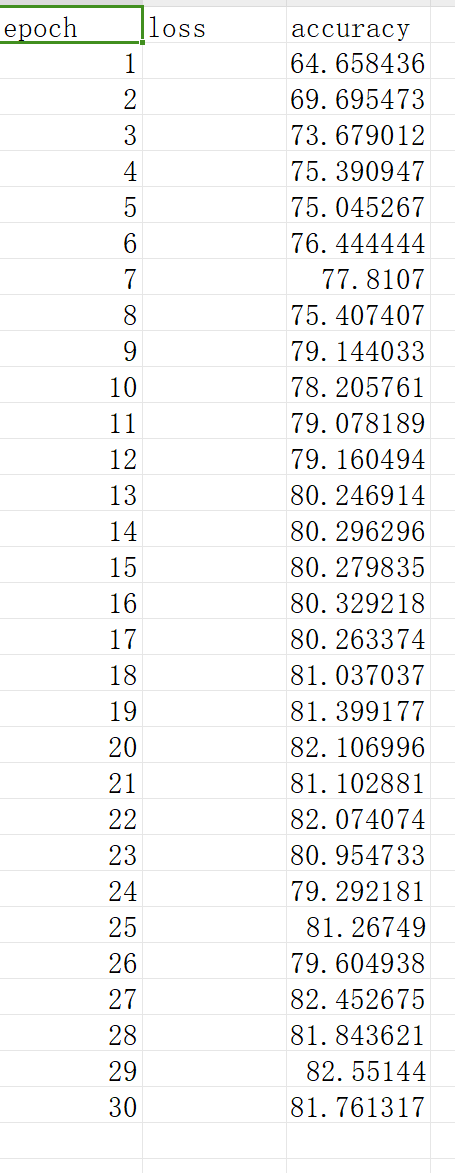

And this is the result of crop processing. The best result result appears at the 27th epoch, which has the val accuracy score 90.6831%.


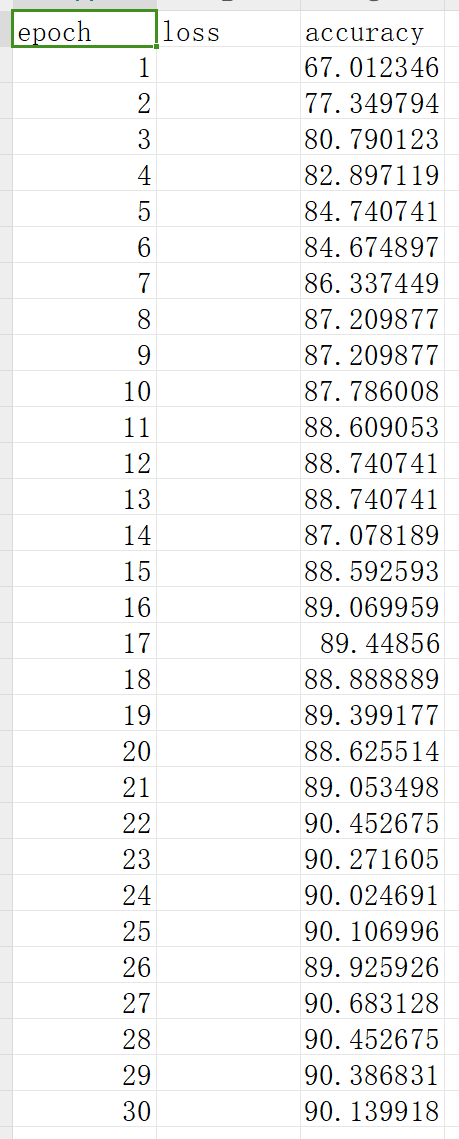

In [ ]:
def cm(true,pred):
    classes=[0,1,2,3,4,5,6,7,8]
    cm=confusion_matrix(true, pred)
    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')

    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)

    print('accuracy_score', accuracy_score(true, pred))
    print('Micro precision', precision_score(true, pred, average='macro'))
    print('Micro recall', recall_score(true, pred, average='macro'))
    print('Micro f1-score', f1_score(true, pred, average='macro'))


    # show confusion matrix
    plt.show()

Here we use the code above to generate the confusion matrix for trainned models.

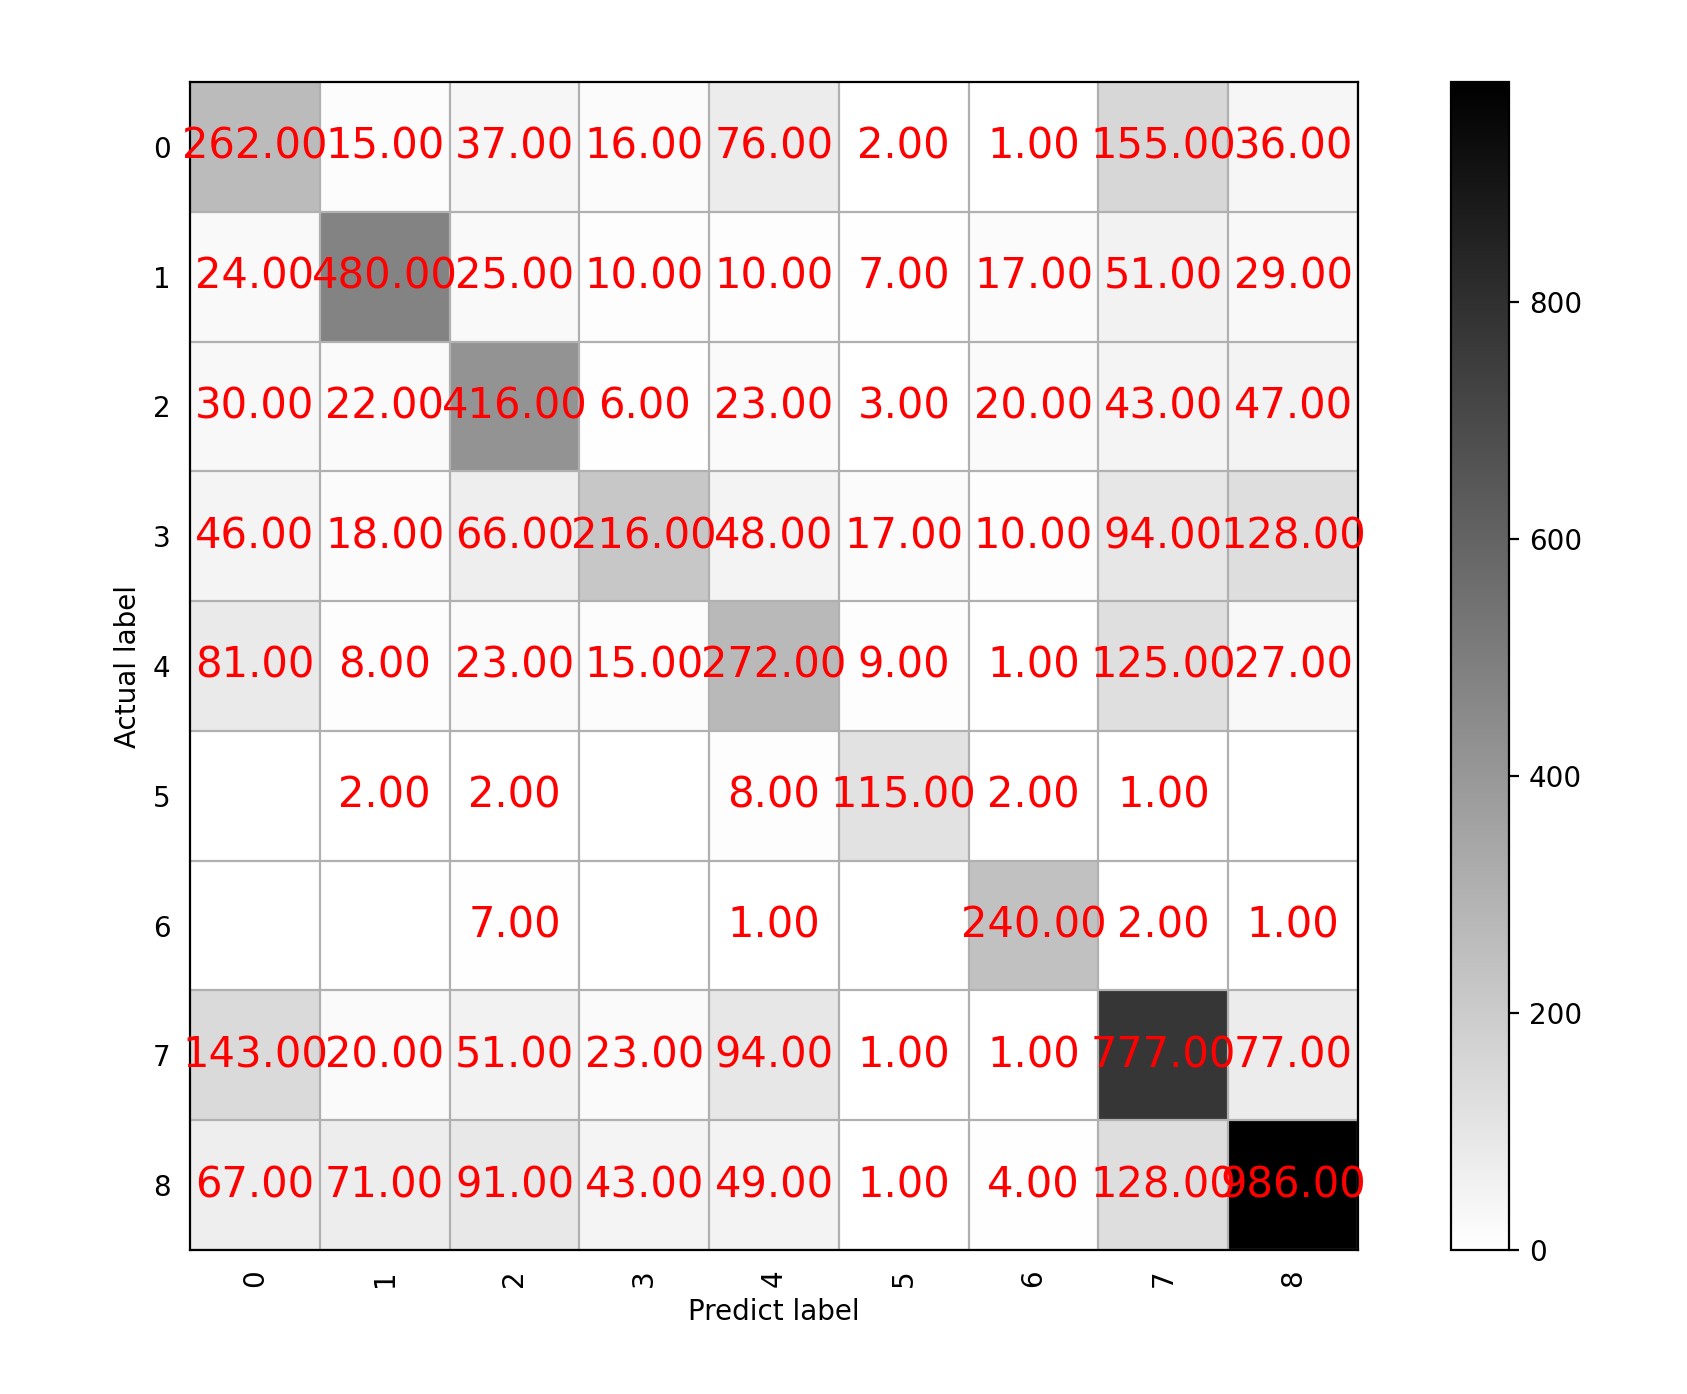

This is the confusion matrix of result of enhancement processing.

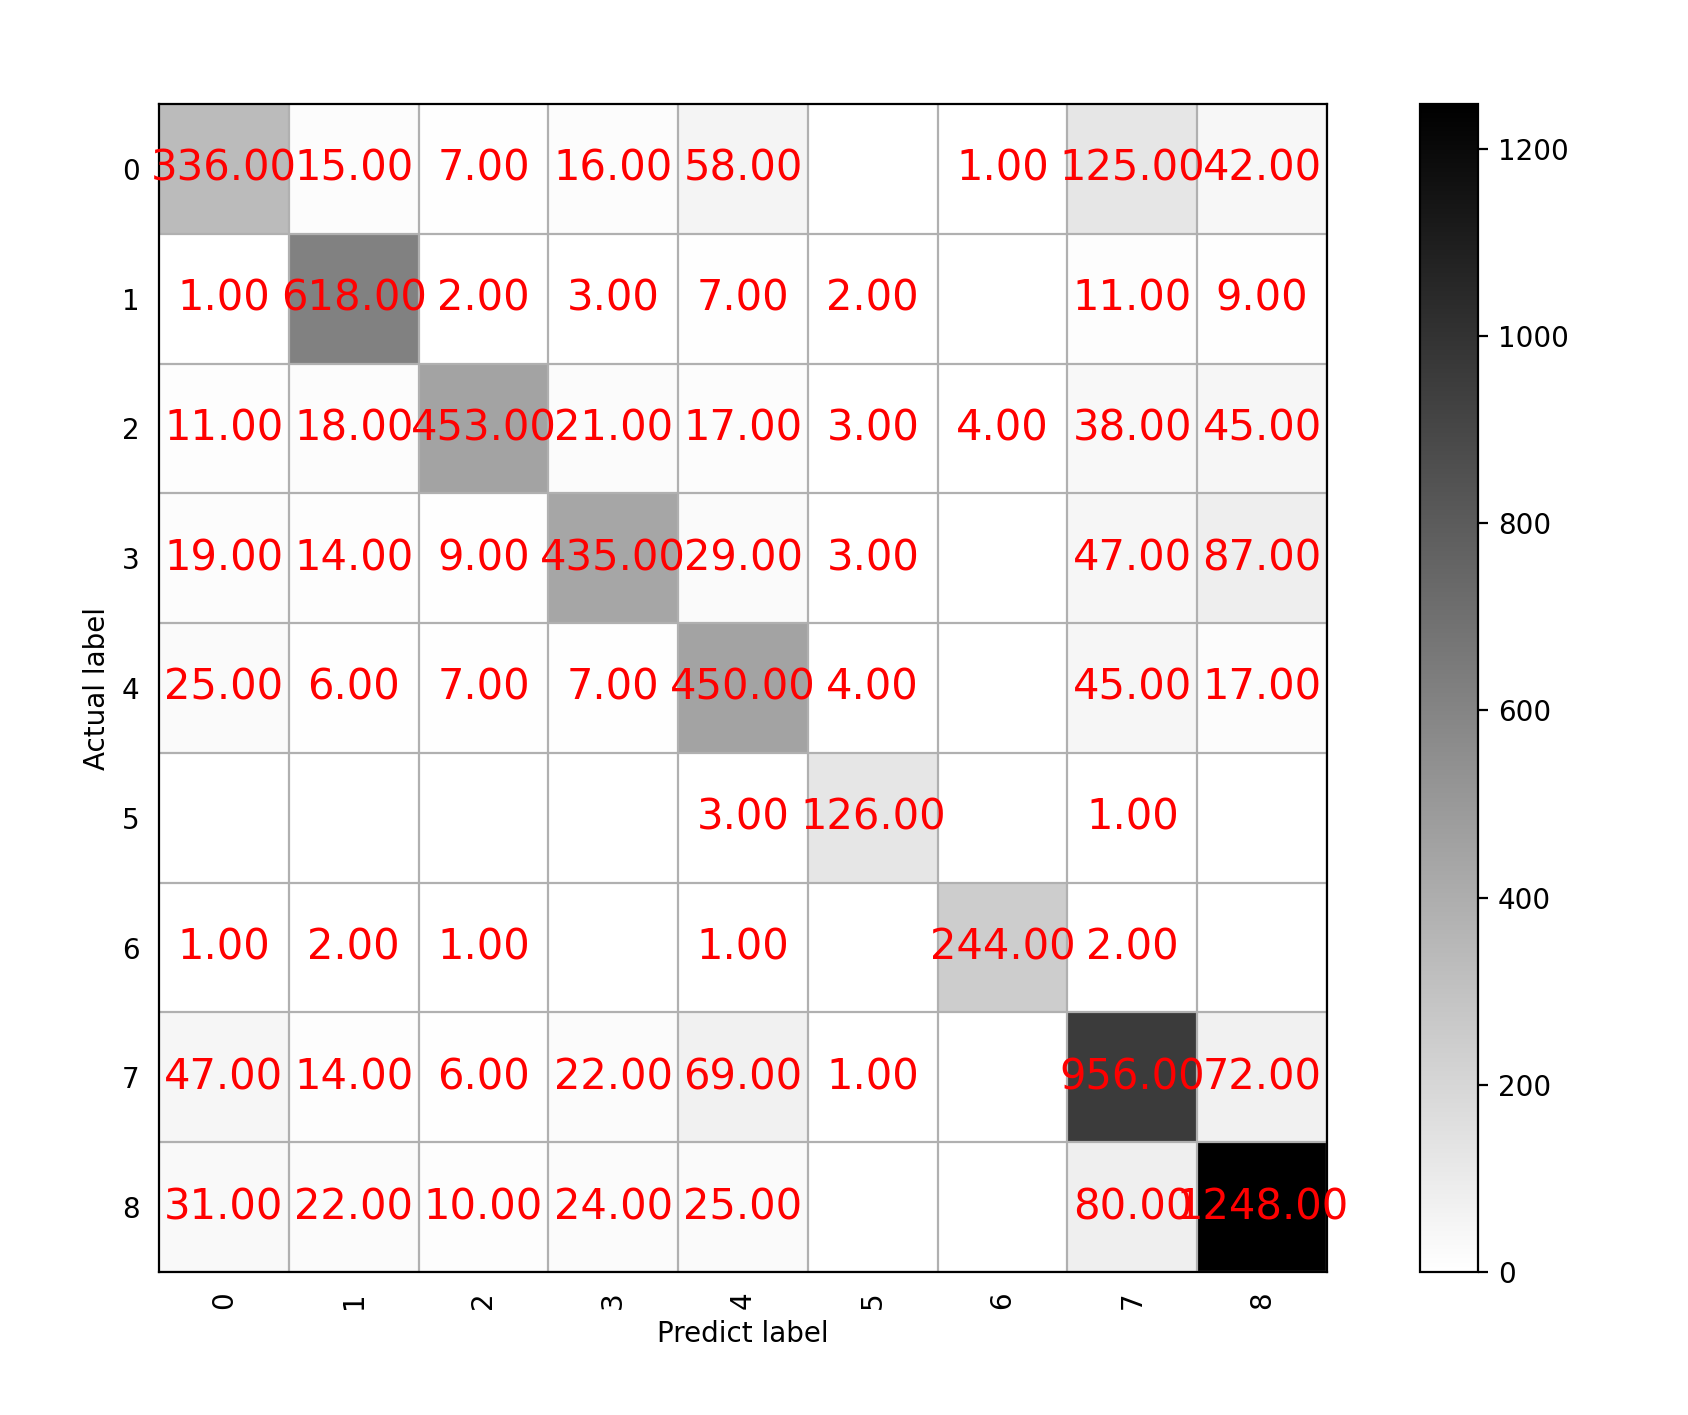

This is the confusion matrix of result of cropped processing.

Now let's assess the precision, recall and f1-score to evaluate the model quality
Following is the scores for cropped processing

Micro precision 0.8274342385321072

Micro recall 0.8156755862940727

Micro f1-score 0.8176456178805268

The model's predictions are correct around 82.74% of the time for positive instances. This means that out of all the instances predicted as positive by the model, approximately 82.74% of them are truly positive. And a recall of 0.8157 indicates that the model correctly identifies around 81.57% of the actual positive instances in the dataset. As for the f1 score, 0.81 indicates that the model's performance is around 81.76% in terms of balancing precision and recall. From these three standards, the performance is not good enough.

while the following data is the scores for enhancement processing

Micro precision 0.6353606117365231

Micro recall 0.6505089933125857

Micro f1-score 0.6347528736008393

As for this result from enhancement processing, the result is even worse.
From these two results, we can conclude that these two ways of pre-processing may not improve the accuracy score but even make it worse (accuracy score decrease from 93.89 to 90.68 and even 82.55).

# ***3.Multitasking learning***

## Analysis and ideas





Based on the previous experiment summary:
1. The fake detection task achieved excellent results with the pre-trained model (resnet50).
2. Interestingly, when detecting and cropping only the face part of the images and using augmented images during data preprocessing, the performance actually decreased.

After analyzing the data, we propose utilizing the labels provided by the data without altering the original data.

It is worth noting that the original data provides three types of labels:
1. Real and fake faces,
2. Five types of manipulated fake faces and four types of real faces,
3. Three types of semantic attributes for fake faces.

We will allow the model to fully learn from these three types of labels and conduct a final voting for real and fake faces.

## Multitasking learning

Multitask learning is a machine learning approach that enables models to learn and optimize multiple tasks simultaneously. The advantage of this method is that it can enhance the model's generalization ability, as the model needs to perform well on multiple tasks, not just one. Additionally, multitask learning can leverage the correlations between different tasks to improve learning efficiency.

## Model & Loss function

Multi-task model class: The MultiTaskModel class defines a multi-task model that consists of a base model and four fully connected layers. During the forward propagation process, the model first extracts features through the base model and then generates four different outputs through the fully connected layers. These outputs correspond to 9-label classification, 4-label classification, 2-label classification, and the final true/false detection.

Loss calculation function: The compute_loss function is used to calculate the loss of the model. It first calculates the cross-entropy loss for each output and its corresponding target label, and then adds these losses together with certain weights to obtain the total loss. Here, the weights are set to prioritize the 9-label and 4-label classifications, as well as the final 2-label classification.

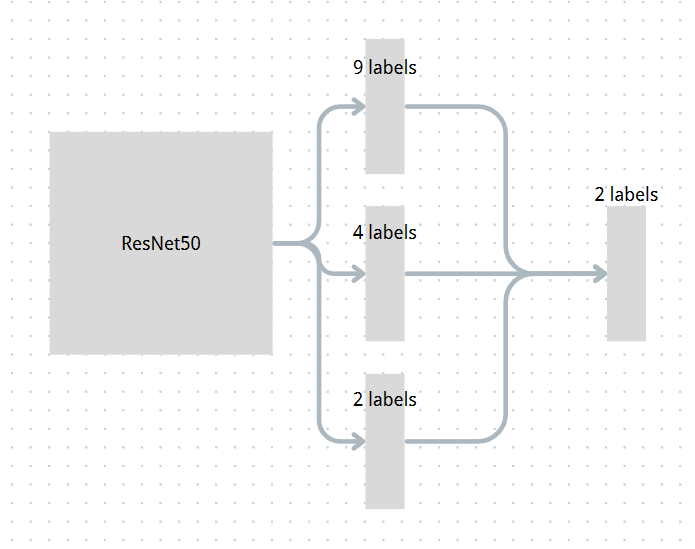

As shown in the above figure, we have incorporated networks after the resnet50 model to learn the following:
1. Real and fake faces,
2. Five types of manipulated fake faces and four types of real faces,
3. Three types of semantic attributes for fake faces.  

Finally, we combine these three results to output the final binary classification (real or fake). This structure allows us to leverage the three labels to gather more information from the images and collectively determine the authenticity based on these three factors.

## Experimental design





This section trained a total of 3 models.  
The first one is the basic model based on resnet50, which achieved the detection of real and fake faces by replacing the last layer with a 2-class fully connected layer.  
The second one is a multi-task learning model.  
The third one is an extension of the multi-task learning model, with another loss function and larger input image size.

# **Attention!**

To repeat the experiment, it is better to create a docker container
The train and val is stored in the /workspace/src:  
train_loader,val_loader = d('/workspace/src/train'), d('/workspace/src/val').  
also you can directly modify the /workspace to the project_data's path

In running commmand,model_path='./ Model.pth ', history_path='./history.csv' is the address to save the model and data  
train_model(train_loader, val_loader, model_path='./model.pth', history_path='./history.csv')

This is the execution of copying the code

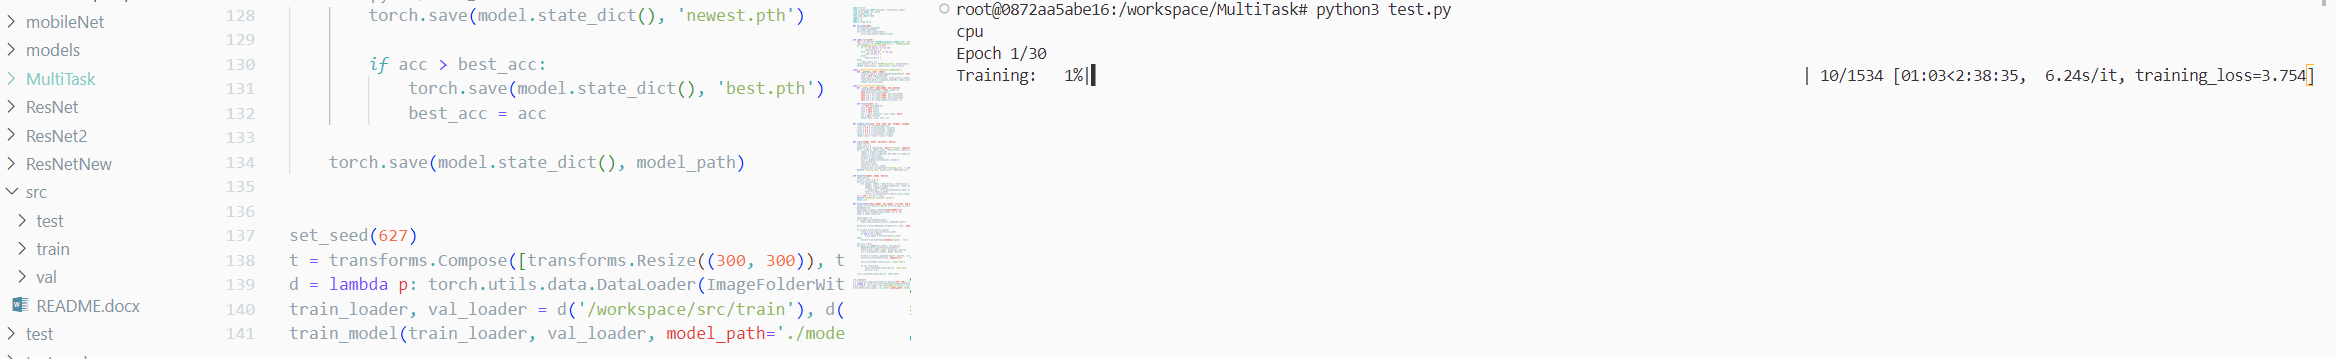

## Preconditioning

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


At the same time, we extract some images from the train and val data sets to form the test set

In [ ]:
import os
import shutil
import random

def extract_test_set(train_dir, val_dir, test_dir, num_images):
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        os.makedirs(os.path.join(test_dir, 'fake'))
        os.makedirs(os.path.join(test_dir, 'real'))
    train_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(train_dir) for f in filenames]
    val_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(val_dir) for f in filenames]
    all_images = train_images + val_images
    chosen_images = random.sample(all_images, num_images)
    for img_path in chosen_images:
        label = 'real' if 'Real' in img_path else 'fake'
        shutil.copy(img_path, os.path.join(test_dir, label))
extract_test_set('/workspace/src/train', '/workspace/src/val', '/workspace/src/test', 8000)

For each of the following models, we will first present the training code. Then, we will load the model parameters on the cloud service and evaluate the accuracy of the test set. Finally, we will compare the three models.

## 3.1 ResNet50_binary_classification

### 3.1.1 code

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import pandas as pd
from tqdm import tqdm
import re
import os
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def label_func(path):
    cls = re.search(r'(FakeManipulation-\d|Real-\d)', path).group()
    label_2class = 0 if 'FakeManipulation' in cls else 1
    return label_2class

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        label_2class = label_func(path)
        tuple_with_path = (original_tuple[0], label_2class)
        return tuple_with_path

def train(loader, model, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    criterion = nn.CrossEntropyLoss()

    for i, (inputs, label) in enumerate(progress_bar):
        inputs = inputs.to(device)
        labels = label.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss/(i+1))})
    print(f'Training Loss: {total_loss / len(loader)}')

def evaluate(loader, model, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels, in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Validation Accuracy: {acc}%')
    return acc

def train_model(train_loader, val_loader, lr=0.001, num_epochs=30, model_path='model.pth', history_path='history.csv'):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    base_model = models.resnet50(pretrained=True)
    num_ftrs = base_model.fc.in_features
    base_model.fc = nn.Linear(num_ftrs, 2)
    model = base_model
    model = model.to(device)

    start_epoch = 0
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if os.path.exists(history_path):
        history = pd.read_csv(history_path)
        if not history.empty:
            start_epoch = history['epoch'].max()
    else:
        history = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

    best_acc = 0.0
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train(train_loader, model, optimizer, device)
        acc = evaluate(val_loader, model, device)

        history = history._append({'epoch': epoch+1, 'accuracy': acc}, ignore_index=True)
        history.to_csv(history_path, index=False)

        torch.save(model.state_dict(), 'newest.pth')

        if acc > best_acc:
            torch.save(model.state_dict(), 'best.pth')
            best_acc = acc

    torch.save(model.state_dict(), model_path)


In [ ]:
t = transforms.Compose([transforms.Resize((164, 164)), transforms.ToTensor()])
d = lambda p: torch.utils.data.DataLoader(ImageFolderWithPaths(p, transform=t), batch_size=32, shuffle=True)
train_loader, val_loader = d("/workspace/src/train"), d("/workspace/src/val")

set_seed(42)
train_model(train_loader, val_loader, model_path='./model.pth', history_path='./history.csv')

### 3.1.2 result

Here we set the random number seed 42 and train the model to save the data of 30 epochs as follows

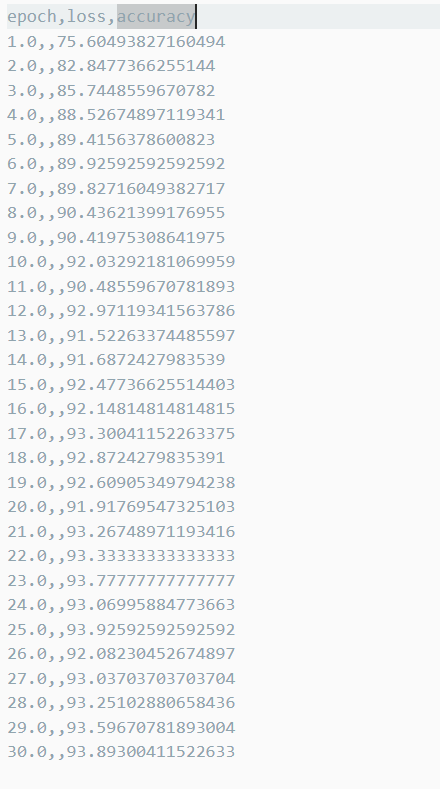

Codes to load the model and evaluate the test set

In [ ]:
import torch
from torchvision import datasets, transforms, models
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from torch import nn
def test(model, data_path):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    t = transforms.Compose([transforms.Resize((164, 164)), transforms.ToTensor()])
    test_data = datasets.ImageFolder(data_path, transform=t)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)


    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    Accuracy = 100 * correct / total
    Recall = recall_score(y_true, y_pred, average='macro')
    Precision = precision_score(y_true, y_pred, average='macro')
    AUC = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')

    return Accuracy, Recall, Precision, AUC

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base_model = models.resnet50(pretrained=True)
num_ftrs = base_model.fc.in_features
base_model.fc = nn.Linear(num_ftrs, 2)
model = base_model
model = model.to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/4487asm/models/ResNet_2c/best.pth'))
data_path = "/content/gdrive/MyDrive/4487asm/test"
test(model, data_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(98.4771573604061, 0.9847969490826634, 0.9847969490826634, 0.9847969490826634)

**Test set result:(98.4771573604061, 0.9847969490826634, 0.9847969490826634, 0.9847969490826634)**  
**Val set result: The best result is 30th epoch, 93.89% accuracy on val dataset**

## 3.2 ResNet50_multi-task_learning

### code

In addition to dividing REAL and FAKE based on labels directly, we separately designed an additional network based on three kinds of labels to distinguish the three kinds of labels and finally divided them into 9 points, 4 points, 2 points, and finally 2 points. The code is as follows:

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import pandas as pd
from tqdm import tqdm
import re
import os
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def label_func(path):
    cls = re.search(r'(FakeManipulation-\d|Real-\d)', path).group()
    label_9class = ['FakeManipulation-1', 'FakeManipulation-2', 'FakeManipulation-3', 'FakeManipulation-4', 'FakeManipulation-5', 'Real-1', 'Real-2', 'Real-3', 'Real-4'].index(cls)
    if 'FakeManipulation' in cls:
        if '-1' in cls or '-2' in cls:
            label_4class = 0
        elif '-3' in cls or '-4' in cls:
            label_4class = 1
        else:
            label_4class = 2
    else:
        label_4class = 3
    label_2class = 0 if 'FakeManipulation' in cls else 1
    return label_9class, label_4class, label_2class

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        label_9class, label_4class, label_2class = label_func(path)
        tuple_with_path = (original_tuple[0], label_2class, label_9class, label_4class, label_2class)
        return tuple_with_path

class MultiTaskModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model
        self.fc1 = nn.Linear(1000, num_classes[0])
        self.fc2 = nn.Linear(1000, num_classes[1])
        self.fc3 = nn.Linear(1000, num_classes[2])
        self.fc4 = nn.Linear(sum(num_classes), 2)

    def forward(self, x):
        x = self.base_model(x)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        out = torch.cat((out1, out2, out3), dim=1)
        out = self.fc4(out)
        return out1, out2, out3, out


def compute_loss(out1, out2, out3, out, target1, target2, target3, target):
    criterion = nn.CrossEntropyLoss()
    loss1 = 0.1 * criterion(out1, target1)
    loss2 = 0.1 * criterion(out2, target2)
    loss3 = 0.1 * criterion(out3, target3)
    loss4 = 0.7 * criterion(out, target)
    return loss1 + loss2 + loss3 + loss4

def train(loader, model, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for i, (inputs, labels_final, label_9class, label_4class, label_2class) in enumerate(progress_bar):
        inputs = inputs.to(device)
        labels = [label.to(device) for label in [label_9class, label_4class, label_2class, labels_final]]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = compute_loss(*outputs, *labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss/(i+1))})
    print(f'Training Loss: {total_loss / len(loader)}')


def evaluate(loader, model, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels, label_9class, label_4class, label_2class in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs[-1].data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Validation Accuracy: {acc}%')
    return acc

def train_model(train_loader, val_loader, lr=0.001, num_epochs=30, model_path='model.pth', history_path='history.csv'):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    base_model = models.resnet50(pretrained=True)
    model = MultiTaskModel(base_model, [9, 4, 2])
    model = model.to(device)

    start_epoch = 0
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if os.path.exists(history_path):
        history = pd.read_csv(history_path)
        if not history.empty:
            start_epoch = history['epoch'].max()
    else:
        history = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

    best_acc = 0.0
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train(train_loader, model, optimizer, device)
        acc = evaluate(val_loader, model, device)

        history = history._append({'epoch': epoch+1, 'accuracy': acc}, ignore_index=True)
        history.to_csv(history_path, index=False)

        torch.save(model.state_dict(), 'newest.pth')

        if acc > best_acc:
            torch.save(model.state_dict(), 'best.pth')
            best_acc = acc

    torch.save(model.state_dict(), model_path)

1. we use label_func to give a entry of data with 3 kinds of labels  
2. Based on its multi-task structure, I designed the loss function to weight loss

In [ ]:
set_seed(56643608)
t = transforms.Compose([transforms.Resize((164, 164)), transforms.ToTensor()])
d = lambda p: torch.utils.data.DataLoader(ImageFolderWithPaths(p, transform=t), batch_size=32, shuffle=True)
train_loader, val_loader = d('/workspace/src/train'), d('/workspace/src/val')
train_model(train_loader, val_loader, model_path='./model.pth', history_path='./history.csv')

### Result

Here we set the random number seed 56643608 and train the model to save the data of 30 epochs as follows

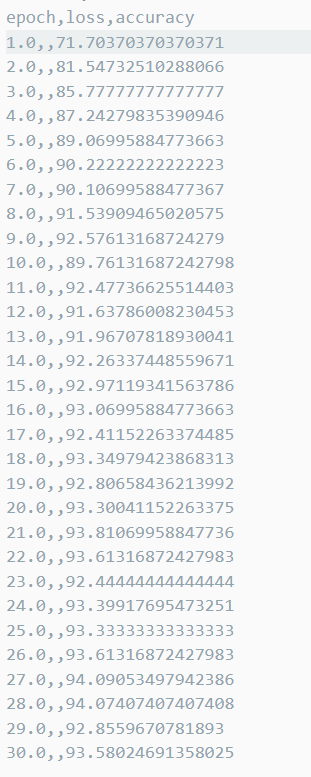

Codes to load the model and evaluate again

In [ ]:
import torch
from torchvision import datasets, transforms, models
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from torch import nn
class MultiTaskModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model
        self.fc1 = nn.Linear(1000, num_classes[0])
        self.fc2 = nn.Linear(1000, num_classes[1])
        self.fc3 = nn.Linear(1000, num_classes[2])
        self.fc4 = nn.Linear(sum(num_classes), 2)

    def forward(self, x):
        x = self.base_model(x)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        out = torch.cat((out1, out2, out3), dim=1)
        out = self.fc4(out)
        return out1, out2, out3, out
def test(model, data_path):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    t = transforms.Compose([transforms.Resize((164, 164)), transforms.ToTensor()])
    test_data = datasets.ImageFolder(data_path, transform=t)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)


    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs[-1].data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    Accuracy = 100 * correct / total
    Recall = recall_score(y_true, y_pred, average='macro')
    Precision = precision_score(y_true, y_pred, average='macro')
    AUC = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')

    return Accuracy, Recall, Precision, AUC


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base_model = models.resnet50(pretrained=True)
model = MultiTaskModel(base_model, [9, 4, 2])
model = model.to(device)
model_pth = '/content/gdrive/MyDrive/4487asm/models/ResNet_mc/best.pth'
data_path = "/content/gdrive/MyDrive/4487asm/test"
model.load_state_dict(torch.load(model_pth))
test(model, data_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(98.4771573604061, 0.9847969490826634, 0.9847969490826634, 0.9847969490826634)

**Test set result:(98.4771573604061, 0.9847969490826634, 0.9847969490826634, 0.9847969490826634)**  
**The best result is 27th epoch, 94.09% accuracy on val dataset**

## 3.3 ResNet50_multi-task_learning_new

### code

In the above multitasking structure, I increased the input image area and new loss function, hoping to achieve better results

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch import nn, optim
import pandas as pd
from tqdm import tqdm
import re
import os
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def label_func(path):
    cls = re.search(r'(FakeManipulation-\d|Real-\d)', path).group()
    label_9class = ['FakeManipulation-1', 'FakeManipulation-2', 'FakeManipulation-3', 'FakeManipulation-4', 'FakeManipulation-5', 'Real-1', 'Real-2', 'Real-3', 'Real-4'].index(cls)
    if 'FakeManipulation' in cls:
        if '-1' in cls or '-2' in cls:
            label_4class = 0
        elif '-3' in cls or '-4' in cls:
            label_4class = 1
        else:
            label_4class = 2
    else:
        label_4class = 3
    label_2class = 0 if 'FakeManipulation' in cls else 1
    return label_9class, label_4class, label_2class

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        label_9class, label_4class, label_2class = label_func(path)
        tuple_with_path = (original_tuple[0], label_2class, label_9class, label_4class, label_2class)
        return tuple_with_path

class MultiTaskModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model
        self.fc1 = nn.Linear(1000, num_classes[0])
        self.fc2 = nn.Linear(1000, num_classes[1])
        self.fc3 = nn.Linear(1000, num_classes[2])
        self.fc4 = nn.Linear(sum(num_classes), 2)

    def forward(self, x):
        x = self.base_model(x)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        out = torch.cat((out1, out2, out3), dim=1)
        out = self.fc4(out)
        return out1, out2, out3, out


def compute_loss(out1, out2, out3, out, target1, target2, target3, target):
    criterion = nn.CrossEntropyLoss()
    loss1 = 0.9 * criterion(out1, target1)
    loss2 = 0.5 * criterion(out2, target2)
    loss3 = 0.3 * criterion(out3, target3)
    loss4 = 1.0 * criterion(out, target)
    return loss1 + loss2 + loss3 + loss4


def train(loader, model, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    for i, (inputs, labels_final, label_9class, label_4class, label_2class) in enumerate(progress_bar):
        inputs = inputs.to(device)
        labels = [label.to(device) for label in [label_9class, label_4class, label_2class, labels_final]]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = compute_loss(*outputs, *labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss/(i+1))})
    print(f'Training Loss: {total_loss / len(loader)}')


def evaluate(loader, model, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels, label_9class, label_4class, label_2class in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs[-1].data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f'Validation Accuracy: {acc}%')
    return acc

def train_model(train_loader, val_loader, lr=0.001, num_epochs=30, model_path='model.pth', history_path='history.csv'):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    base_model = models.resnet50(pretrained=True)
    model = MultiTaskModel(base_model, [9, 4, 2])
    model = model.to(device)

    start_epoch = 0
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    if os.path.exists(history_path):
        history = pd.read_csv(history_path)
        if not history.empty:
            start_epoch = history['epoch'].max()
    else:
        history = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

    best_acc = 0.0
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train(train_loader, model, optimizer, device)
        acc = evaluate(val_loader, model, device)

        history = history._append({'epoch': epoch+1, 'accuracy': acc}, ignore_index=True)
        history.to_csv(history_path, index=False)

        torch.save(model.state_dict(), 'newest.pth')

        if acc > best_acc:
            torch.save(model.state_dict(), 'best.pth')
            best_acc = acc

    torch.save(model.state_dict(), model_path)

In [ ]:
set_seed(627)
t = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()])
d = lambda p: torch.utils.data.DataLoader(ImageFolderWithPaths(p, transform=t), batch_size=32, shuffle=True)
train_loader, val_loader = d('/workspace/src/train'), d('/workspace/src/val')
train_model(train_loader, val_loader, model_path='./model.pth', history_path='./history.csv')

### Result

Here we set the random number seed 627 and train the model to save the data of 30 epochs as follows

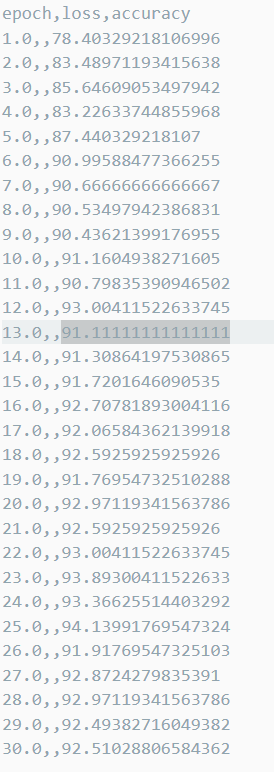

Codes to load the model and test



In [ ]:
import torch
from torchvision import datasets, transforms, models
from sklearn.metrics import recall_score, precision_score, roc_auc_score
from torch import nn
class MultiTaskModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model
        self.fc1 = nn.Linear(1000, num_classes[0])
        self.fc2 = nn.Linear(1000, num_classes[1])
        self.fc3 = nn.Linear(1000, num_classes[2])
        self.fc4 = nn.Linear(sum(num_classes), 2)

    def forward(self, x):
        x = self.base_model(x)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        out = torch.cat((out1, out2, out3), dim=1)
        out = self.fc4(out)
        return out1, out2, out3, out
def test(model, data_path):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    t = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()])
    test_data = datasets.ImageFolder(data_path, transform=t)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)


    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs[-1].data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    Accuracy = 100 * correct / total
    Recall = recall_score(y_true, y_pred, average='macro')
    Precision = precision_score(y_true, y_pred, average='macro')
    AUC = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovo')

    return Accuracy, Recall, Precision, AUC


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base_model = models.resnet50(pretrained=True)
model = MultiTaskModel(base_model, [9, 4, 2])
model = model.to(device)
model_pth = '/content/gdrive/MyDrive/4487asm/models/ResNet_mc_new/best.pth'
data_path = "/content/gdrive/MyDrive/4487asm/test"
model.load_state_dict(torch.load(model_pth))
test(model, data_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(98.73096446700508, 0.987322201607916, 0.9873096446700507, 0.987322201607916)

**Test set result:(98.73096446700508, 0.987322201607916, 0.9873096446700507, 0.987322201607916)**  
**The best result is 25th epoch, 94.13% accuracy on val dataset**

## 3.4 Conclusion

### **Result analysis**

After examining the aforementioned code and experimental results, the multi-task model (94.13%, 98.73%) outperforms the resnet50 model (93.89%, 98.47%) in terms of val accuracy and test accuracy. Additionally, it converges faster.  
In many attempts, although the highest value of the network accuracy of the final multi-task is only a part of that of the ordinary resnet50, its initial accuracy is always higher than that of the ordinary resnet50, so we use the multi-task network as the final model. At the same time, because the accuracy of deepening the network is not obvious and may cause other problems in the future, we do not carry out deeper network construction.  

Final model, load and evaluate the model, the code can be trace back in 3.3

### **Optimize**

Furthermore, by deepening the network and adding structures, adjusting the loss weight can make the network more powerful than the native ResNet50. The following section provides a detailed analysis and optimization of the main structures.

1.Deepening networks: One way to deepen networks is by adding more layers, such as inserting additional hidden layers between fully connected layers. This can assist the model in learning more complex feature representations, but it may also lead to overfitting. To prevent overfitting, regularization techniques like dropout or weight decay can be employed.  

2.Using more complex loss functions: One can consider utilizing more intricate loss functions, such as adversarial loss or focal loss, which may enhance the performance of the model on imbalanced datasets.

### **Limitation**

Increasing the complexity of the network and using more sophisticated loss functions simultaneously can enhance performance. However, due to computational limitations, further attempts often end in failure. Nevertheless, the results confirm that deepening the network and adjusting the weights can improve accuracy.

### **Final Report**

1.We provide the multitasking model, where (94.13%, 98.73%) outperforms the resnet50 model (93.89%, 98.47%) in terms of val accuracy and test accuracy

2.After conducting experiments, it has been confirmed that adjusting the weight of the loss function and utilizing a more intricate loss function can lead to faster convergence and improved outcomes.

3.A deeper network structure and larger output images can also enhance the effectiveness.